# Flatiron Health mBC: MICE

**OBJECTIVE: Impute missing variables in the training dataset using multiple imputation chained equations (MICE). Five non-missing training sets will be construced using MICE along with 5 test sets. A gradient boosted model will be fit to each training dataset and a test set AUC will be calculated. The 1 year AUCs from the test set will be pooled to get a final estimate.** 

**BACKGROUND: The variables with the most missingness at time of advanced diagnosis are ECOG (50%), labs (30%), and changes in weight (11%). These three variables have high predictive value in our models. Up until this point, missingness has been handled by making "unknown" a level in the ECOG variable and imputing median for lab values and weight loss. While this imputation strategy is simple and fast, it likely understimates the variance of variables and disturb relations between variables when the data is not missing completely at random.** 

**Variables that will be imputed with MICE:** 
1. **ECOG (48% missing)**
2. **BMI (15% missing)**
3. **Weight (25% missing)**
4. **Percent change in weight and weight slope (11% missing)**
5. **Socioeconomic status (20% missing)**
6. **Stage (6%)**
7. **Labs at time of advanced diagnosis (30% missing)**
8. **Subset of summary labs (40% missing)**

**Five complete training sets will be imputed using the Python package "miceforest" which uses lightgbm as a backend. Five complete test sets will also be imputed from the final model used to impute the training set values. All existing variables including outcome variables like death status and time until event will be utilized to aid in the imputations. In addition, auxillary variables such as receipt of treatment, weight and BMI at 3 months, and labs at 3 months will be created to augment imputations.**   

**After complete training and test sets are constructed, a gradient boosted survival model will be built for each training set in the same fashion as in the crude imputation notebook. Final test AUCs will be pooled using Rubin's rules.**

**OUTLINE:**
1. **Building auxillary variables** 
2. **Performing MICE on training and test sets** 
3. **Building gradient boosting models on imputed datasets**
4. **Pooling results**

## 1. Building auxillary varibles 

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Function that returns number of rows and count of unique PatientIDs for a dataframe. 
def row_ID(dataframe):
    row = dataframe.shape[0]
    ID = dataframe['PatientID'].nunique()
    return row, ID

### 1.1 Preprocessing

In [3]:
train = pd.read_csv('train_full.csv')
row_ID(train)

(25341, 25341)

In [4]:
test = pd.read_csv('test_full.csv')
row_ID(test)

(6336, 6336)

In [5]:
df = pd.concat([train, test], ignore_index = True)
row_ID(df)

(31677, 31677)

### 1.2 Treatment 

**Add indicator variables for first, second, and third line treatment. Treatment will be defined as having received an FDA approved targeted agent for the treatment of metastatic breast cancer.** 

In [6]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [7]:
line_therapy = line_therapy[line_therapy['PatientID'].isin(df['PatientID'])]

In [8]:
# List of FDA approved drugs for mBC as of May 2023. Clinical study drug is also included. 
fda_yes = [
    'Abemaciclib',
    'Alpelisib',
    'Anastrozole',
    'Atezolizumab',
    'Avelumab',
    'Capecitabine',
    'Carboplatin',
    'Cisplatin',
    'Cyclophosphamide',
    'Docetaxel',
    'Elacestrant',
    'Epirubicin',
    'Everolimus',
    'Exemestane',
    'Fluorouracil',
    'Fulvestrant',
    'Gemcitabine',
    'Goserelin',
    'Ixabepilone',
    'Letrozole',
    'Olaparib',
    'Paclitaxel',
    'Paclitaxel Protein-Bound',
    'Palbociclib',
    'Pembrolizumab',
    'Pertuzumab ',
    'Ribociclib',
    'Sacituzumab Govitecan-Hziy',
    'Talazoparib',
    'Tamoxifen',
    'Trastuzumab',
    'Ado-Trastuzumab Emtansine',
    'Fam-Trastuzumab Deruxtecan-Nxki',
    'Vinorelbine',
    'Clinical Study Drug'
]

In [9]:
line_therapy_1 = (
    line_therapy.query('LineNumber == 1')
    .query('IsMaintenanceTherapy == False')
    .drop_duplicates(subset = 'PatientID', keep = 'first'))

line_therapy_2 = (
    line_therapy.query('LineNumber == 2')
    .query('IsMaintenanceTherapy == False')
    .drop_duplicates(subset = 'PatientID', keep = 'first'))

line_therapy_3 = (
    line_therapy.query('LineNumber == 3')
    .query('IsMaintenanceTherapy == False')
    .drop_duplicates(subset = 'PatientID', keep = 'first'))

line_therapy_4 = (
    line_therapy.query('LineNumber == 4')
    .query('IsMaintenanceTherapy == False')
    .drop_duplicates(subset = 'PatientID', keep = 'first'))

In [10]:
line_therapy_1.loc[:, 'line_1'] = np.where(
    line_therapy_1['LineName'].str.contains('|'.join(fda_yes)), 1, 0)

line_therapy_2.loc[:, 'line_2'] = np.where(
    line_therapy_2['LineName'].str.contains('|'.join(fda_yes)), 1, 0)

line_therapy_3.loc[:, 'line_3'] = np.where(
    line_therapy_3['LineName'].str.contains('|'.join(fda_yes)), 1, 0)

line_therapy_4.loc[:, 'line_4'] = np.where(
    line_therapy_4['LineName'].str.contains('|'.join(fda_yes)), 1, 0)

In [11]:
line_therapy_1 = line_therapy_1[['PatientID', 'line_1']]
line_therapy_2 = line_therapy_2[['PatientID', 'line_2']]
line_therapy_3 = line_therapy_3[['PatientID', 'line_3']]
line_therapy_4 = line_therapy_4[['PatientID', 'line_4']]

In [12]:
df = pd.merge(df, line_therapy_1, on = 'PatientID', how = 'outer')
df = pd.merge(df, line_therapy_2, on = 'PatientID', how = 'outer')
df = pd.merge(df, line_therapy_3, on = 'PatientID', how = 'outer')
df = pd.merge(df, line_therapy_4, on = 'PatientID', how = 'outer')

In [13]:
df[['line_1', 'line_2', 'line_3', 'line_4']] = df[['line_1', 'line_2', 'line_3', 'line_4']].fillna(value = 0)

In [14]:
df.line_1.value_counts()

1.0    27055
0.0     4622
Name: line_1, dtype: int64

In [15]:
df.line_2.value_counts()

1.0    16915
0.0    14762
Name: line_2, dtype: int64

In [16]:
df.line_3.value_counts()

0.0    21226
1.0    10451
Name: line_3, dtype: int64

In [17]:
df.line_4.value_counts()

0.0    25205
1.0     6472
Name: line_4, dtype: int64

In [18]:
row_ID(df)

(31677, 31677)

In [19]:
del line_therapy
del line_therapy_1
del line_therapy_2
del line_therapy_3
del line_therapy_4

### 1.3 Weight

In [20]:
vitals = pd.read_csv('Vitals.csv')

vitals = vitals[vitals['PatientID'].isin(df['PatientID'])]

In [21]:
enhanced_met = enhanced_met = pd.read_csv('Enhanced_MetastaticBreast.csv')

enhanced_met = enhanced_met[enhanced_met['PatientID'].isin(df['PatientID'])]
                                                              
enhanced_met.loc[:, 'MetDiagnosisDate'] = pd.to_datetime(enhanced_met['MetDiagnosisDate'])

enhanced_met = enhanced_met.rename(columns = {'MetDiagnosisDate': 'met_date'})

#### Weight and BMI

In [22]:
# Create weight dataframe; remove weight values that are empty or equal to zero.
weight = (
    vitals
    .query('Test == "body weight"')
    .filter(items = ['PatientID', 'TestDate', 'TestResultCleaned'])
    .rename(columns = {'TestResultCleaned': 'weight'})
    .dropna(subset = ['weight'])
    .query('weight != 0')
)

In [23]:
weight.loc[:, 'TestDate'] = pd.to_datetime(weight['TestDate'])

In [24]:
weight = pd.merge(weight, enhanced_met[['PatientID', 'met_date']], on = 'PatientID', how = 'left')

In [25]:
# Weight elgibliity window is -60 to +60 from 6 months after metastatic diagnosis. 
weight_win_bmi = (
    weight
    .assign(weight_date_diff = ((weight['TestDate'] - (weight['met_date'] + pd.DateOffset(days = 180))).dt.days))
    .query('weight_date_diff >= -60 and weight_date_diff <= 60')
)

In [26]:
weight_win_bmi.loc[:, 'weight_date_diff'] = weight_win_bmi['weight_date_diff'].abs()

In [27]:
# Select weight closest to +180 from metastatic diagnosis; lowest weight selected in the event of two weights on same day or equidistant. 
weight_bmi_wide = (
    weight_win_bmi
    .sort_values(by = ['PatientID', 'weight_date_diff', 'weight'], ascending = [True, True, True])
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    .filter(items = ['PatientID', 'weight'])
    .rename(columns = {'weight': 'weight_180'})
)

In [28]:
# Dataframe of average height for each patient. 
height_avg = (
    vitals
    .query('Test == "body height"')
    .filter(items = ['PatientID', 'TestResultCleaned'])
    .groupby('PatientID')['TestResultCleaned'].mean()
    .to_frame()
    .reset_index()
    .rename(columns = {'TestResultCleaned': 'height_avg'})
)

In [29]:
weight_bmi_wide = pd.merge(weight_bmi_wide, height_avg, on = 'PatientID', how = 'left')

In [30]:
# Create BMI column. 
weight_bmi_wide = (
    weight_bmi_wide
    .assign(bmi_180 = lambda x: (x['weight_180']/(x['height_avg']*x['height_avg']))*10000)
    .drop(columns = ['height_avg'])
)

In [31]:
df = pd.merge(df, weight_bmi_wide, on = 'PatientID', how = 'outer')

In [32]:
row_ID(df)

(31677, 31677)

#### Percent change in weight 

In [33]:
# Select elgbility window of -90 to +365 days from metastatic diagnosis.
weight_win_summary = (
    weight
    .assign(weight_date_diff = (weight['TestDate'] - weight['met_date']).dt.days)
    .query('weight_date_diff >= -90 and weight_date_diff <= 365')
)

In [34]:
# Select patients with more than 1 weight recording within elgibility window.
weight_win_summary = weight_win_summary[weight_win_summary.duplicated(subset = ['PatientID'], keep = False)]

In [35]:
# Select weight from the earliest time within elgibility window. 
weight_tmin = weight_win_summary.loc[weight_win_summary.groupby('PatientID')['weight_date_diff'].idxmin()]

In [36]:
# Select weight from the latest time within elgibility window. 
weight_tmax = weight_win_summary.loc[weight_win_summary.groupby('PatientID')['weight_date_diff'].idxmax()]

In [37]:
# Combine above two dataframes and sort from earliest recorded weight to latest recorded weight for each patient. 
weight_tcomb = (
    pd.concat([weight_tmin, weight_tmax])
    .sort_values(by = ['PatientID', 'weight_date_diff'], ascending = True)
)

In [38]:
weight_tcomb.loc[:, 'weight_pct_1yr'] = weight_tcomb.groupby('PatientID')['weight'].pct_change()

In [39]:
# Drop empty rows for weight_pct_change.
weight_pct_wide = (
    weight_tcomb
    .dropna(subset = ['weight_pct_1yr'])
    .filter(items = ['PatientID', 'weight_pct_1yr'])
)

In [40]:
df = pd.merge(df, weight_pct_wide, on = 'PatientID', how = 'outer')

In [41]:
row_ID(df)

(31677, 31677)

#### Slope of weight 

In [42]:
import datetime as dt
from scipy.stats import linregress 

In [43]:
weight_win_summary.loc[:, 'date_ordinal'] = weight_win_summary['TestDate'].map(dt.datetime.toordinal)

In [44]:
# Dataframe of slope for weight recordings within window period (kg/day).
weight_slope_wide = (
    weight_win_summary
    .groupby('PatientID')
    .apply(lambda x: pd.Series(linregress(x['date_ordinal'], x['weight'])))
    .rename(columns = {0: 'weight_slope_1yr'})
    .reset_index()
    .filter(items = ['PatientID', 'weight_slope_1yr'])) 

/Applications/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm


In [45]:
df = pd.merge(df, weight_slope_wide, on = 'PatientID', how = 'outer')

In [46]:
row_ID(df)

(31677, 31677)

In [47]:
del height_avg
del vitals
del weight
del weight_bmi_wide
del weight_pct_wide
del weight_slope_wide
del weight_tcomb
del weight_tmax
del weight_tmin
del weight_win_bmi
del weight_win_summary

### 1.4 Static labs 

In [48]:
lab = pd.read_csv('Lab.csv')

In [49]:
lab = lab[lab['PatientID'].isin(df['PatientID'])]

In [50]:
lab = pd.merge(lab, enhanced_met[['PatientID', 'met_date']], on = 'PatientID', how = 'left')

In [51]:
lab.loc[:, 'ResultDate'] = pd.to_datetime(lab['ResultDate']) 

In [52]:
# Select rows with clinically relevant labs.
lab_core = (
    lab[
    (lab['LOINC'] == "2160-0") |
    (lab['LOINC'] == "38483-4") | 
    (lab['LOINC'] == "718-7") |
    (lab['LOINC'] == "20509-6") |
    (lab['LOINC'] == "26464-8") |
    (lab['LOINC'] == "6690-2") |
    (lab['LOINC'] == "26499-4") |
    (lab['LOINC'] == "751-8") |
    (lab['LOINC'] == "30451-9") |
    (lab['LOINC'] == "753-4") |
    (lab['LOINC'] == "1751-7") |
    (lab['LOINC'] == "42719-5") |
    (lab['LOINC'] == "1975-2") |
    (lab['LOINC'] == "2947-0") |
    (lab['LOINC'] == "2951-2") |
    (lab['LOINC'] == "1963-8") |
    (lab['LOINC'] == "1959-6") |
    (lab['LOINC'] == "14627-4") |
    (lab['LOINC'] == "1960-4") |
    (lab['LOINC'] == "2028-9") |
    (lab['LOINC'] == "17861-6") |
    (lab['LOINC'] == "49765-1") |
    (lab['LOINC'] == "1920-8") |
    (lab['LOINC'] == "1742-6") | 
    (lab['LOINC'] == "1743-4") |
    (lab['LOINC'] == "1744-2") |
    (lab['LOINC'] == "26515-7") | 
    (lab['LOINC'] == "777-3") |
    (lab['LOINC'] == "778-1") |
    (lab['LOINC'] == "49497-1") | 
    (lab['LOINC'] == "6298-4") |
    (lab['LOINC'] == "2823-3") |
    (lab['LOINC'] == "2075-0") | 
    (lab['LOINC'] == "3094-0") | 
    (lab['LOINC'] == "6768-6")]
    .filter(items = ['PatientID', 
                     'ResultDate', 
                     'LOINC', 
                     'LabComponent', 
                     'TestUnits', 
                     'TestUnitsCleaned', 
                     'TestResult', 
                     'TestResultCleaned', 
                     'met_date'])
)

In [53]:
conditions = [
    ((lab_core['LOINC'] == '2160-0') | (lab_core['LOINC'] == '38483-4')),
    ((lab_core['LOINC'] == '718-7') | (lab_core['LOINC'] == '20509-6')),
    ((lab_core['LOINC'] == '26464-8') | (lab_core['LOINC'] == '6690-2')), 
    ((lab_core['LOINC'] == '26499-4') | (lab_core['LOINC'] == '751-8') | (lab_core['LOINC'] == '30451-9') | (lab_core['LOINC'] == '753-4')),
    (lab_core['LOINC'] == '1751-7'),
    ((lab_core['LOINC'] == '42719-5') | (lab_core['LOINC'] == '1975-2')),
    ((lab_core['LOINC'] == '2947-0') | (lab_core['LOINC'] == '2951-2')),
    ((lab_core['LOINC'] == '1963-8') | (lab_core['LOINC'] == '1959-6') | (lab_core['LOINC'] == '14627-4') | (lab_core['LOINC'] == '1960-4') | (lab_core['LOINC'] == '2028-9')),
    ((lab_core['LOINC'] == '17861-6') | (lab_core['LOINC'] == '49765-1')),
    (lab_core['LOINC'] == '1920-8'),
    ((lab_core['LOINC'] == '1742-6') | (lab_core['LOINC'] == '1743-4') | (lab_core['LOINC'] == '1744-2')),
    ((lab_core['LOINC'] == '26515-7') | (lab_core['LOINC'] == '777-3') | (lab_core['LOINC'] == '778-1') | (lab_core['LOINC'] == '49497-1')),
    ((lab_core['LOINC'] == '6298-4') | (lab_core['LOINC'] == '2823-3')),
    (lab_core['LOINC'] == '2075-0'), 
    (lab_core['LOINC'] == '3094-0'),
    (lab_core['LOINC'] == '6768-6')]

choices = ['creatinine', 
           'hemoglobin', 
           'wbc', 
           'neutrophil_count',  
           'albumin', 
           'total_bilirubin', 
           'sodium', 
           'bicarb',
           'calcium',
           'ast', 
           'alt',
           'platelet',
           'potassium', 
           'chloride',
           'bun',
           'alp']

lab_core.loc[:, 'lab_name'] = np.select(conditions, choices)

In [54]:
lab_core = (
    lab_core
    .dropna(subset = ['TestResultCleaned'])
)

In [55]:
conditions = [
    ((lab_core['lab_name'] == 'wbc') | (lab_core['lab_name'] == 'neutrophil_count') | (lab_core['lab_name'] == 'platelet')) & 
    (lab_core['TestUnits'] == '10*3/L'),
    (lab_core['lab_name'] == 'hemoglobin') & (lab_core['TestUnits'] == 'g/uL')]

choices = [lab_core['TestResultCleaned'] * 1000000,
           lab_core['TestResultCleaned'] / 100000]

lab_core.loc[:, 'test_result_cleaned'] = np.select(conditions, choices, default = lab_core['TestResultCleaned'])

In [56]:
# Elgibliity window is +30 to +330 from metastatic diagnosis. 
lab_core_win = (
    lab_core
    .assign(lab_date_diff = ((lab_core['ResultDate'] - (lab_core['met_date'] + pd.DateOffset(days = 180))).dt.days))
    .query('lab_date_diff >= -150 and lab_date_diff <= 150')
    .filter(items = ['PatientID', 'ResultDate', 'TestResultCleaned', 'lab_name', 'met_date', 'test_result_cleaned', 'lab_date_diff'])
)

In [57]:
lab_core_win.loc[:, 'lab_date_diff'] = lab_core_win['lab_date_diff'].abs()

In [58]:
# Select lab closest to 180 days after metastatic diagnosis and then pivot to a wide table. 
lab_180_wide = (
    lab_core_win
    .loc[lab_core_win.groupby(['PatientID', 'lab_name'])['lab_date_diff'].idxmin()]
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'test_result_cleaned')
    .reset_index()
    .rename(columns = {
        'albumin': 'albumin_180',
        'creatinine': 'creatinine_180',
        'hemoglobin': 'hemoglobin_180',
        'neutrophil_count': 'neutrophil_count_180',
        'total_bilirubin': 'total_bilirubin_180',
        'wbc': 'wbc_180',
        'sodium': 'sodium_180', 
        'bicarb': 'bicarb_180',
        'calcium': 'calcium_180',
        'ast': 'ast_180', 
        'alt': 'alt_180',
        'platelet': 'platelet_180',
        'potassium': 'potassium_180',
        'chloride': 'chloride_180',
        'bun': 'bun_180', 
        'alp': 'alp_180'})
)

lab_180_wide.columns.name = None

In [59]:
df = pd.merge(df, lab_180_wide, on = 'PatientID', how = 'outer')

In [60]:
row_ID(df)

(31677, 31677)

### 1.5 Summary labs

In [61]:
# Elgibility window is negative infinity to +365 from metastatic diagnosis. 
lab_core_win_summ = (
    lab_core
    .assign(lab_date_diff = (lab_core['ResultDate'] - lab_core['met_date']).dt.days)
    .query('lab_date_diff <= 365')
    .filter(items = ['PatientID', 'ResultDate', 'TestResultCleaned', 'lab_name', 'met_date', 'test_result_cleaned', 'lab_date_diff'])
)

In [62]:
# Pivot table of maximum values for core labs during elgibility period of -inf to +150 days from advanced diagnosis. 
lab_max_wide = (
    lab_core_win_summ
    .groupby(['PatientID', 'lab_name'])['test_result_cleaned'].max()
    .to_frame()
    .reset_index()
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'test_result_cleaned')
    .filter(items = ['alp', 'alt', 'ast', 'calcium', 'creatinine', 'total_bilirubin', 'wbc'])
    .reset_index()
    .rename(columns = {
        'alp': 'alp_max_f',
        'alt': 'alt_max_f',
        'ast': 'ast_max_f',
        'calcium': 'calcium_max_f',
        'creatinine': 'creatinine_max_f',
        'total_bilirubin': 'total_bilirubin_max_f',
        'wbc': 'wbc_max_f'})
)

lab_max_wide.columns.name = None

In [63]:
# Pivot table of minimum values for core labs during elgibility period of -inf to +150 days from advanced diagnosis. 
lab_min_wide = (
    lab_core_win_summ
    .groupby(['PatientID', 'lab_name'])['test_result_cleaned'].min()
    .to_frame()
    .reset_index()
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'test_result_cleaned')
    .filter(items = ['albumin', 'bicarb', 'hemoglobin', 'platelet', 'sodium', 'wbc'])
    .reset_index()
    .rename(columns = {
        'albumin': 'albumin_min_f',
        'bicarb': 'bicarb_min_f',
        'hemoglobin': 'hemoglobin_min_f',
        'platelet': 'platelet_min_f',
        'sodium': 'sodium_min_f', 
        'wbc': 'wbc_min_f'})
)

lab_min_wide.columns.name = None

In [64]:
df = pd.merge(df, lab_max_wide, on = 'PatientID', how = 'outer')

In [65]:
row_ID(df)

(31677, 31677)

In [66]:
df = pd.merge(df, lab_min_wide, on = 'PatientID', how = 'outer')

In [67]:
row_ID(df)

(31677, 31677)

In [68]:
del enhanced_met
del lab
del lab_180_wide
del lab_core
del lab_core_win
del lab_core_win_summ
del lab_max_wide
del lab_min_wide

### 1.6 Replacing 'unknown' with np.nan for variables of interest

In [69]:
df = df.replace({'stage': {'unknown': np.nan, '0': 'I'},
                 'ecog_diagnosis': {'unknown': np.nan}})

In [70]:
df.stage.value_counts(dropna = False)

IV     9762
II     8165
III    6416
NaN    3757
I      3577
Name: stage, dtype: int64

In [71]:
df.ecog_diagnosis.value_counts(dropna = False)

NaN    17518
0.0     6813
1.0     4908
2.0     1718
3.0      645
4.0       75
Name: ecog_diagnosis, dtype: int64

### 1.7 Dropping unwanted summary variables 

In [72]:
# Pasted from crude_model_building file 
drop_labs = [
    'albumin_avg',
    'alp_avg',
    'alt_avg',
    'ast_avg',
    'bicarb_avg',
    'bun_avg',
    'calcium_avg',
    'chloride_avg',
    'creatinine_avg',
    'hemoglobin_avg',
    'neutrophil_count_avg',
    'platelet_avg',
    'potassium_avg',
    'sodium_avg',
    'total_bilirubin_avg',
    'wbc_avg',
    'albumin_max',
    'bicarb_max',
    'bun_max',
    'chloride_max',
    'hemoglobin_max',
    'neutrophil_count_max',
    'platelet_max',
    'potassium_max',
    'sodium_max',
    'alp_min',
    'alt_min',
    'ast_min',
    'bun_min',
    'calcium_min',
    'chloride_min',
    'creatinine_min',
    'neutrophil_count_min',
    'potassium_min',
    'total_bilirubin_min',
    'albumin_std',
    'alp_std',
    'alt_std',
    'ast_std',
    'bicarb_std',
    'bun_std',
    'calcium_std',
    'chloride_std',
    'creatinine_std',
    'hemoglobin_std',
    'neutrophil_count_std',
    'platelet_std',
    'potassium_std',
    'sodium_std',
    'total_bilirubin_std',
    'wbc_std',
    'albumin_slope',
    'alp_slope',
    'alt_slope',
    'ast_slope',
    'bicarb_slope',
    'bun_slope',
    'calcium_slope',
    'chloride_slope',
    'creatinine_slope',
    'hemoglobin_slope',
    'neutrophil_count_slope',
    'platelet_slope',
    'potassium_slope',
    'sodium_slope',
    'total_bilirubin_slope',
    'wbc_slope',
    'albumin_slope_na',
    'alp_slope_na',
    'alt_slope_na',
    'ast_slope_na',
    'bicarb_slope_na',
    'bun_slope_na',
    'calcium_slope_na',
    'chloride_slope_na',
    'creatinine_slope_na',
    'hemoglobin_slope_na',
    'neutrophil_count_slope_na',
    'platelet_slope_na',
    'potassium_slope_na',
    'sodium_slope_na',
    'total_bilirubin_slope_na',
    'wbc_slope_na']

In [73]:
df = df.drop(columns = drop_labs)

In [74]:
df.shape

(31677, 171)

In [75]:
df.loc[:, 'alp_max_na'] = np.where(df['alp_max'].isna(), 1, 0)
df.loc[:, 'alt_max_na'] = np.where(df['alt_max'].isna(), 1, 0)
df.loc[:, 'ast_max_na'] = np.where(df['ast_max'].isna(), 1, 0)
df.loc[:, 'calcium_max_na'] = np.where(df['calcium_max'].isna(), 1, 0)
df.loc[:, 'creatinine_max_na'] = np.where(df['creatinine_max'].isna(), 1, 0)
df.loc[:, 'total_bilirubin_max_na'] = np.where(df['total_bilirubin_max'].isna(), 1, 0)
df.loc[:, 'wbc_max_na'] = np.where(df['wbc_max'].isna(), 1, 0)
df.loc[:, 'albumin_min_na'] = np.where(df['albumin_min'].isna(), 1, 0)
df.loc[:, 'bicarb_min_na'] = np.where(df['bicarb_min'].isna(), 1, 0)
df.loc[:, 'hemoglobin_min_na'] = np.where(df['hemoglobin_min'].isna(), 1, 0)
df.loc[:, 'platelet_min_na'] = np.where(df['platelet_min'].isna(), 1, 0)
df.loc[:, 'sodium_min_na'] = np.where(df['sodium_min'].isna(), 1, 0)
df.loc[:, 'wbc_min_na'] = np.where(df['wbc_min'].isna(), 1, 0)

In [76]:
df.shape

(31677, 184)

In [77]:
row_ID(df)

(31677, 31677)

In [78]:
df_mice = df

In [79]:
df_mice.to_csv('df_mice.csv', index = False, header = True)

### 1.8 Final processing

In [80]:
train_mice = df_mice[df_mice['PatientID'].isin(train['PatientID'])]
train_mice = train_mice.set_index('PatientID')

In [81]:
test_mice = df_mice[df_mice['PatientID'].isin(test['PatientID'])]
test_mice = test_mice.set_index('PatientID')

In [82]:
train_mice.shape

(25341, 183)

In [83]:
test_mice.shape

(6336, 183)

In [84]:
list(train_mice.select_dtypes(include = ['object']).columns)

['gender',
 'race',
 'ethnicity',
 'p_type',
 'region',
 'stage',
 'ER',
 'HER2',
 'PR',
 'BRCA',
 'PIK3CA',
 'pdl1_n',
 'ecog_diagnosis']

In [85]:
to_be_categorical = list(train_mice.select_dtypes(include = ['object']).columns)

In [86]:
to_be_categorical.append('met_year')

In [87]:
to_be_categorical.append('ses')

In [88]:
# miceforest requires columns to be category or int/float, so object columns will be converted to category. 
for x in list(to_be_categorical):
    train_mice[x] = train_mice[x].astype('category')

In [89]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    test_mice[x] = test_mice[x].astype('category')

In [90]:
list(train_mice.select_dtypes(include = ['category']).columns)

['gender',
 'race',
 'ethnicity',
 'p_type',
 'region',
 'stage',
 'met_year',
 'ER',
 'HER2',
 'PR',
 'BRCA',
 'PIK3CA',
 'pdl1_n',
 'ecog_diagnosis',
 'ses']

In [91]:
# List of variable that have missing values which MICE will impute. 
list(train_mice.columns[train_mice.isnull().any()])

['stage',
 'ecog_diagnosis',
 'weight_diag',
 'bmi_diag',
 'weight_pct_change',
 'weight_slope',
 'albumin_diag',
 'alp_diag',
 'alt_diag',
 'ast_diag',
 'bicarb_diag',
 'bun_diag',
 'calcium_diag',
 'chloride_diag',
 'creatinine_diag',
 'hemoglobin_diag',
 'neutrophil_count_diag',
 'platelet_diag',
 'potassium_diag',
 'sodium_diag',
 'total_bilirubin_diag',
 'wbc_diag',
 'alp_max',
 'alt_max',
 'ast_max',
 'calcium_max',
 'creatinine_max',
 'total_bilirubin_max',
 'wbc_max',
 'albumin_min',
 'bicarb_min',
 'hemoglobin_min',
 'platelet_min',
 'sodium_min',
 'wbc_min',
 'ses',
 'weight_180',
 'bmi_180',
 'weight_pct_1yr',
 'weight_slope_1yr',
 'albumin_180',
 'alp_180',
 'alt_180',
 'ast_180',
 'bicarb_180',
 'bun_180',
 'calcium_180',
 'chloride_180',
 'creatinine_180',
 'hemoglobin_180',
 'neutrophil_count_180',
 'platelet_180',
 'potassium_180',
 'sodium_180',
 'total_bilirubin_180',
 'wbc_180',
 'alp_max_f',
 'alt_max_f',
 'ast_max_f',
 'calcium_max_f',
 'creatinine_max_f',
 'total_

In [92]:
len(train_mice.columns[train_mice.isnull().any()])

69

## 2. Building training and test set using miceforest 

In [93]:
import miceforest as mf

### 2.1 Finding ideal parameters

In [94]:
# Create kernel. 
kernel = mf.ImputationKernel(
    train_mice,
    datasets = 5,
    save_all_iterations = True,
    random_state = 42)

In [95]:
# Using the first ImputationKernel in kernel to tune parameters with the default settings.
optimal_parameters, losses = kernel.tune_parameters(
    dataset = 0,
    optimization_steps = 5,
    verbose = 1,
    random_state = 42)

stage | 0 - 1 - 2 - 3 - 4 - 
hemoglobin_min_f | 0 - 1 - 2 - 3 - 4 - 
creatinine_max_f | 0 - 1 - 2 - 3 - 4 - 
alp_max_f | 0 - 1 - 2 - 3 - 4 - 
ast_max_f | 0 - 1 - 2 - 3 - 4 - 
weight_pct_1yr | 0 - 1 - 2 - 3 - 4 - 
calcium_max_f | 0 - 1 - 2 - 3 - 4 - 
weight_slope_1yr | 0 - 1 - 2 - 3 - 4 - 
wbc_max_f | 0 - 1 - 2 - 3 - 4 - 
wbc_min_f | 0 - 1 - 2 - 3 - 4 - 
alt_max_f | 0 - 1 - 2 - 3 - 4 - 
total_bilirubin_max_f | 0 - 1 - 2 - 3 - 4 - 
albumin_min_f | 0 - 1 - 2 - 3 - 4 - 
platelet_min_f | 0 - 1 - 2 - 3 - 4 - 
hemoglobin_180 | 0 - 1 - 2 - 3 - 4 - 
weight_pct_change | 0 - 1 - 2 - 3 - 4 - 
weight_slope | 0 - 1 - 2 - 3 - 4 - 
sodium_min_f | 0 - 1 - 2 - 3 - 4 - 
ses | 0 - 1 - 2 - 3 - 4 - 
creatinine_180 | 0 - 1 - 2 - 3 - 4 - 
bicarb_min_f | 0 - 1 - 2 - 3 - 4 - 
bun_180 | 0 - 1 - 2 - 3 - 4 - 
weight_diag | 0 - 1 - 2 - 3 - 4 - 
bmi_diag | 0 - 1 - 2 - 3 - 4 - 
alp_180 | 0 - 1 - 2 - 3 - 4 - 
ast_180 | 0 - 1 - 2 - 3 - 4 - 
calcium_180 | 0 - 1 - 2 - 3 - 4 - 
alt_180 | 0 - 1 - 2 - 3 - 4 - 
wbc_180 | 0 -

### 2.2 Building training datasets

In [96]:
# Run mice with our newly tuned parameters.
kernel.mice(iterations = 5, 
            variable_parameters = optimal_parameters,
            verbose = 0)

In [97]:
for x in range(5): 
    kernel.complete_data(dataset = x).to_csv('mice_tr'+str(x)+'.csv', index = True, header = True)

### 2.3 Building test datasets

In [98]:
test_imputed = kernel.impute_new_data(new_data = test_mice, verbose = 0)

In [99]:
for x in range(5): 
    test_imputed.complete_data(dataset = x).to_csv('mice_te'+str(x)+'.csv', index = True, header = True)

## 3. Building gradient boosting models 

In [100]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import StratifiedKFold, HalvingGridSearchCV

from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.metrics import cumulative_dynamic_auc, as_cumulative_dynamic_auc_scorer

from joblib import dump, load

import matplotlib.pyplot as plt

import warnings

### 3.1 Model 0

#### Preprocessing and building pipeline 

In [101]:
# Import first training set
train_mice0 = pd.read_csv('mice_tr0.csv', index_col = 'PatientID')

# Import all test sets
test_mice0 = pd.read_csv('mice_te0.csv', index_col = 'PatientID')
test_mice1 = pd.read_csv('mice_te1.csv', index_col = 'PatientID')
test_mice2 = pd.read_csv('mice_te2.csv', index_col = 'PatientID')
test_mice3 = pd.read_csv('mice_te3.csv', index_col = 'PatientID')
test_mice4 = pd.read_csv('mice_te4.csv', index_col = 'PatientID')

In [102]:
# Combine all test sets into 1 to get more robust estimates from models
test_mice = pd.concat([test_mice0, test_mice1, test_mice2, test_mice3, test_mice4], ignore_index = False)

In [103]:
print(train_mice0.shape)
print(test_mice.shape)

(25341, 183)
(31680, 183)


In [104]:
# Auxillary variables generated for MICE
train_mice0.columns[train_mice0.columns.str.contains('_1|_2|_3|_4|_180|_1yr|x_f|n_f')]

Index(['line_1', 'line_2', 'line_3', 'line_4', 'weight_180', 'bmi_180',
       'weight_pct_1yr', 'weight_slope_1yr', 'albumin_180', 'alp_180',
       'alt_180', 'ast_180', 'bicarb_180', 'bun_180', 'calcium_180',
       'chloride_180', 'creatinine_180', 'hemoglobin_180',
       'neutrophil_count_180', 'platelet_180', 'potassium_180', 'sodium_180',
       'total_bilirubin_180', 'wbc_180', 'alp_max_f', 'alt_max_f', 'ast_max_f',
       'calcium_max_f', 'creatinine_max_f', 'total_bilirubin_max_f',
       'wbc_max_f', 'albumin_min_f', 'bicarb_min_f', 'hemoglobin_min_f',
       'platelet_min_f', 'sodium_min_f', 'wbc_min_f'],
      dtype='object')

In [105]:
#Remove auxillary variables for train and test sets
mice_drop = train_mice0.columns[train_mice0.columns.str.contains('_1|_2|_3|_4|_180|_1yr|x_f|n_f')]

train_mice0 = train_mice0.drop(columns = mice_drop)

test_mice = test_mice.drop(columns = mice_drop)

In [106]:
print(train_mice0.shape)
print(test_mice.shape)

(25341, 146)
(31680, 146)


In [107]:
# Generate ecog_na, stage_na, and ses_na indicator variables
train_mice0['ecog_na'] = np.where(train_mice0.index.isin(train.query('ecog_diagnosis == "unknown"').PatientID), 1, 0)
train_mice0['stage_na'] = np.where(train_mice0.index.isin(train.query('stage == "unknown"').PatientID), 1, 0)
train_mice0['ses_na'] = np.where(train_mice0.index.isin(train[train['ses'].isnull()].PatientID), 1, 0)

test_mice['ecog_na'] = np.where(test_mice.index.isin(test.query('ecog_diagnosis == "unknown"').PatientID), 1, 0)
test_mice['stage_na'] = np.where(test_mice.index.isin(test.query('stage == "unknown"').PatientID), 1, 0)
test_mice['ses_na'] = np.where(test_mice.index.isin(test[test['ses'].isnull()].PatientID), 1, 0)

In [108]:
# List of cateogrical varaibles 
to_be_categorical

['gender',
 'race',
 'ethnicity',
 'p_type',
 'region',
 'stage',
 'ER',
 'HER2',
 'PR',
 'BRCA',
 'PIK3CA',
 'pdl1_n',
 'ecog_diagnosis',
 'met_year',
 'ses']

In [109]:
# Convert object variables to categorical variables for train and test 
for x in list(to_be_categorical):
    train_mice0[x] = train_mice0[x].astype('category')
    
for x in list(to_be_categorical):
    test_mice[x] = test_mice[x].astype('category')

In [110]:
list(train_mice0.select_dtypes(include = ['category']).columns)

['gender',
 'race',
 'ethnicity',
 'p_type',
 'region',
 'stage',
 'met_year',
 'ER',
 'HER2',
 'PR',
 'BRCA',
 'PIK3CA',
 'pdl1_n',
 'ecog_diagnosis',
 'ses']

In [111]:
# Death status to boolean 
train_mice0['death_status'] = train_mice0['death_status'].astype('bool')

test_mice['death_status'] = test_mice['death_status'].astype('bool')

In [112]:
#Define validation and subtrain
val_IDs = pd.read_csv('val_IDs.csv')

val_mice0 = train_mice0[train_mice0.index.isin(val_IDs['PatientID'])]

sub_train_mice0 = train_mice0[~train_mice0.index.isin(val_IDs['PatientID'])]

In [113]:
print(train_mice0.shape)
print(sub_train_mice0.shape)
print(val_mice0.shape)

(25341, 149)
(19005, 149)
(6336, 149)


In [114]:
# 'X' datasets
train_mice0_x = train_mice0.drop(columns = ['death_status', 'timerisk_activity'])

sub_train_mice0_x = sub_train_mice0.drop(columns = ['death_status', 'timerisk_activity'])

val_mice0_x = val_mice0.drop(columns = ['death_status', 'timerisk_activity'])

test_mice_x = test_mice.drop(columns = ['death_status', 'timerisk_activity'])

In [115]:
print(train_mice0_x.shape)
print(sub_train_mice0_x.shape)
print(val_mice0_x.shape)
print(test_mice_x.shape)

(25341, 147)
(19005, 147)
(6336, 147)
(31680, 147)


In [116]:
# 'Y' datasets 
y_dtypes = train_mice0[['death_status', 'timerisk_activity']].dtypes

train_y = np.array([tuple(x) for x in train[['death_status', 'timerisk_activity']].values],
                   dtype = list(zip(y_dtypes.index, y_dtypes)))

sub_train_y = np.array([tuple(x) for x in sub_train_mice0[['death_status', 'timerisk_activity']].values],
                       dtype = list(zip(y_dtypes.index, y_dtypes)))

val_y = np.array([tuple(x) for x in val_mice0[['death_status', 'timerisk_activity']].values],
                 dtype = list(zip(y_dtypes.index, y_dtypes)))

test_y = np.array([tuple(x) for x in test_mice[['death_status', 'timerisk_activity']].values],
                  dtype = list(zip(y_dtypes.index, y_dtypes)))

In [117]:
# List of numeric variables, excluding binary variables. 
numerical_features_red = [
    'age',
    'delta_met_diagnosis',
    'weight_diag',
    'bmi_diag',
    'weight_pct_change',
    'weight_slope',
    'albumin_diag',
    'alp_diag',
    'alt_diag',
    'ast_diag',
    'bicarb_diag',
    'bun_diag',
    'calcium_diag',
    'chloride_diag',
    'creatinine_diag',
    'hemoglobin_diag',
    'neutrophil_count_diag',
    'platelet_diag',
    'potassium_diag',
    'sodium_diag',
    'total_bilirubin_diag',
    'wbc_diag',
    'alp_max',
    'alt_max',
    'ast_max',
    'calcium_max',
    'creatinine_max',
    'total_bilirubin_max',
    'wbc_max',
    'albumin_min',
    'bicarb_min',
    'hemoglobin_min',
    'platelet_min',
    'sodium_min',
    'wbc_min',
    'icd_count']

# List of categorical features.
categorical_features = list(train_mice0_x.select_dtypes(include = ['category']).columns)

# Transformer will apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('std_scaler', StandardScaler())])

# One-hot-encode categorical features.
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [118]:
preprocessor_red = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features_red),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

#### Hyperparameter tuning

In [119]:
sub_train_mice0_xt = preprocessor_red.fit_transform(sub_train_mice0_x)
val_mice0_xt = preprocessor_red.transform(val_mice0_x)

gbm_mice0_exp = GradientBoostingSurvivalAnalysis(n_estimators = 1500,
                                                 learning_rate = 0.05,
                                                 max_depth = 2,
                                                 subsample = 0.75,
                                                 verbose = 1,
                                                 random_state = 42)

gbm_mice0_exp.fit(sub_train_mice0_xt, sub_train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       71486.6537          13.6932          156.26m
         2       71593.3370          12.1245          155.92m
         3       71429.5907          13.0942          155.67m
         4       71121.1095          11.8263          155.47m
         5       71456.2212          11.6839          155.29m
         6       71502.3974          11.1078          155.14m
         7       71189.2698          10.7863          155.07m
         8       71116.8238          10.2958          155.08m
         9       71256.2372          10.1900          155.18m
        10       71396.5103           9.8287          155.00m
        20       70244.7257           7.3632          153.99m
        30       70398.6930           6.2941          152.77m
        40       70180.0088           4.5492          151.68m
        50       70334.2403           4.1247          150.61m
        60       70228.8505           3.1997          149.56m
       

GradientBoostingSurvivalAnalysis(learning_rate=0.05, n_estimators=1500,
                                 random_state=42, subsample=0.75, verbose=1)

In [120]:
gbm0_staged_auc = [cumulative_dynamic_auc(sub_train_y, val_y, risk_score, 730)[0][0] for 
                   risk_score in gbm_mice0_exp.staged_predict(val_mice0_xt)]

In [121]:
gbm0_staged_auc_tr = [cumulative_dynamic_auc(sub_train_y, sub_train_y, risk_score, 730)[0][0] for 
                      risk_score in gbm_mice0_exp.staged_predict(sub_train_mice0_xt)]

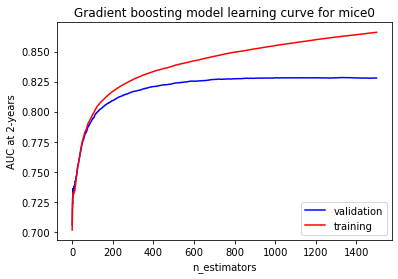

In [122]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = range(len(gbm0_staged_auc))
plt.plot(x, gbm0_staged_auc, color = 'blue', label = 'validation')
plt.plot(x, gbm0_staged_auc_tr, color = 'red', label = 'training')
plt.legend(loc = 'lower right')

plt.xlabel("n_estimators")
plt.ylabel("AUC at 2-years")
plt.title('Gradient boosting model learning curve for mice0')

plt.show()

In [123]:
# Average AUC for every 25 additional trees. 
mean_auc_list = []
for x in np.arange(0, len(gbm0_staged_auc), 25):
    mean_auc_list.append(np.mean(gbm0_staged_auc[x:x+24]))

In [124]:
print('Number of trees where 2 year AUC on validation dataset beings to downgrade:', np.where(np.diff(mean_auc_list) < 0)[0][0]*25)
print('Validation dataset AUC before degrading:', gbm0_staged_auc[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])
print('Training dataset AUC before degrading:', gbm0_staged_auc_tr[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])

Number of trees where 2 year AUC on validation dataset beings to downgrade: 950
Validation dataset AUC before degrading: 0.8279813537864475
Training dataset AUC before degrading: 0.8535997435375878


In [125]:
pipe = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = 950,
                                                                        learning_rate = 0.05,
                                                                        random_state = 42))

# 3 fold cross-validation
cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)

# Parameter gird 
param_grid = {'estimator__gradientboostingsurvivalanalysis__max_depth': [2, 3, 4], 
              'estimator__gradientboostingsurvivalanalysis__subsample': [0.5, 0.75, 0.9]}

gbm_search = HalvingGridSearchCV(
    as_cumulative_dynamic_auc_scorer(pipe, 730),
    param_grid,
    cv = cv,
    factor = 2,
    resource = 'n_samples',
    refit = False,
    verbose = 1,
    random_state = 42,
    n_jobs = -1)

# Run search 
warnings.filterwarnings('ignore')
gbm_search.fit(train_mice0_x, train_y)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 3167
max_resources_: 25341
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 9
n_resources: 3167
Fitting 3 folds for each of 9 candidates, totalling 27 fits
----------
iter: 1
n_candidates: 5
n_resources: 6334
Fitting 3 folds for each of 5 candidates, totalling 15 fits
----------
iter: 2
n_candidates: 3
n_resources: 12668
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 3
n_candidates: 2
n_resources: 25336
Fitting 3 folds for each of 2 candidates, totalling 6 fits


HalvingGridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                    estimator=as_cumulative_dynamic_auc_scorer(estimator=Pipeline(steps=[('columntransformer',
                                                                                          ColumnTransformer(remainder='passthrough',
                                                                                                            transformers=[('num',
                                                                                                                           Pipeline(steps=[('std_scaler',
                                                                                                                                            StandardScaler())]),
                                                                                                                           ['age',
                                                                                                 

In [126]:
gbm_search.best_params_

{'estimator__gradientboostingsurvivalanalysis__max_depth': 2,
 'estimator__gradientboostingsurvivalanalysis__subsample': 0.75}

In [127]:
gbm_search_results = pd.DataFrame(gbm_search.cv_results_)

In [128]:
gbm_search_results.sort_values(by = 'rank_test_score').head(10)

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__gradientboostingsurvivalanalysis__max_depth,param_estimator__gradientboostingsurvivalanalysis__subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
17,3,25336,9104.667341,17.761246,0.243450,0.047879,2,0.75,{'estimator__gradientboostingsurvivalanalysis_...,0.809185,0.818170,0.824667,0.817341,0.006348,1,0.840967,0.832619,0.829496,0.834361,0.004842
18,3,25336,9422.612843,4.513168,0.153548,0.006057,2,0.9,{'estimator__gradientboostingsurvivalanalysis_...,0.809478,0.818202,0.824217,0.817299,0.006051,2,0.840849,0.833212,0.829231,0.834431,0.004821
14,2,12668,3084.414463,3.194644,0.086715,0.005558,2,0.9,{'estimator__gradientboostingsurvivalanalysis_...,0.809897,0.815289,0.821874,0.815687,0.004898,3,0.849285,0.845804,0.836305,0.843798,0.005486
15,2,12668,2971.069851,10.396806,0.190622,0.003707,2,0.75,{'estimator__gradientboostingsurvivalanalysis_...,0.810448,0.813830,0.821218,0.815165,0.004497,4,0.848824,0.845094,0.837265,0.843728,0.004817
16,2,12668,2391.849584,878.086623,0.144036,0.036410,3,0.5,{'estimator__gradientboostingsurvivalanalysis_...,0.808310,0.814805,0.821653,0.814922,0.005448,5,0.878380,0.877199,0.867543,0.874374,0.004855
13,1,6334,584.912473,6.678386,0.055149,0.002999,3,0.5,{'estimator__gradientboostingsurvivalanalysis_...,0.815019,0.812415,0.795854,0.807763,0.008487,6,0.901856,0.901176,0.896074,0.899702,0.002580
9,1,6334,700.908791,2.762714,0.119253,0.011488,2,0.75,{'estimator__gradientboostingsurvivalanalysis_...,0.815903,0.808408,0.794035,0.806116,0.009073,7,0.862394,0.859692,0.852152,0.858079,0.004334
10,1,6334,755.786020,3.827807,0.122648,0.014185,2,0.9,{'estimator__gradientboostingsurvivalanalysis_...,0.815886,0.805902,0.795180,0.805656,0.008455,8,0.861004,0.857608,0.850233,0.856282,0.004496
11,1,6334,688.839468,48.808770,0.142027,0.041827,4,0.5,{'estimator__gradientboostingsurvivalanalysis_...,0.815658,0.809880,0.791178,0.805572,0.010448,9,0.941953,0.941382,0.939288,0.940874,0.001146
12,1,6334,596.838833,2.856332,0.081885,0.011507,2,0.5,{'estimator__gradientboostingsurvivalanalysis_...,0.815323,0.805311,0.795691,0.805442,0.008016,10,0.861003,0.857204,0.853835,0.857347,0.002928


**The above best tree depth and subsample will be used for all models moving forward mainly due to the computational cost of searching for these parameters (5-8 hours) for each MICE training set. It also seems likely that these two hyperparamters have small impact on test set AUC performance and are unlikely to change by much for each training set.** 

#### Building model and assessing performance 

In [129]:
gbm_mice0 = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = 950,
                                                                             learning_rate = 0.05,
                                                                             max_depth = 2,
                                                                             subsample = 0.75,
                                                                             verbose = 1,
                                                                             random_state = 42))

gbm_mice0.fit(train_mice0_x, train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       98560.1227          13.6526          176.95m
         2       98553.4837          13.3793          177.15m
         3       99003.4387          11.9946          176.58m
         4       98606.1393          11.8068          176.38m
         5       98465.6085          10.7649          176.24m
         6       98147.1380          10.7207          176.41m
         7       98422.4823          10.6690          176.43m
         8       98514.6416           9.2309          176.33m
         9       98365.1305           9.0771          176.45m
        10       98575.7543           8.6737          176.72m
        20       98332.9847           6.5076          174.75m
        30       97803.5796           4.5031          173.47m
        40       97604.7102           7.6191          171.17m
        50       97679.9575           3.7314          168.88m
        60       97322.9266           4.1731          166.71m
       

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'delta_met_diagnosis',
                                                   'weight_diag', 'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                                                   'bicarb_diag', 'bun_diag',
                                                   'calcium_diag',
                                                   'chloride_diag',
           

In [130]:
dump(gbm_mice0, 'gbm_mice0.joblib') 

['gbm_mice0.joblib']

In [131]:
gbm_risk_scores_te = gbm_mice0.predict(test_mice_x)
gbm_auc_te = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, 730)[0][0]
print('Test set AUC at 2 years:', gbm_auc_te)

Test set AUC at 2 years: 0.8159118111574662


In [132]:
gbm_risk_scores_tr = gbm_mice0.predict(train_mice0_x)
gbm_auc_tr = cumulative_dynamic_auc(train_y, train_y, gbm_risk_scores_tr, 730)[0][0]
print('Training set AUC at 2 years:', gbm_auc_tr)

Training set AUC at 2 years: 0.8312021748697866


In [133]:
# Bootstrap 10000 1 yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_te), len(gbm_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], gbm_risk_scores_te[indices], 730)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [134]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.002722982683200812


In [135]:
# Bootstrap 10000 1-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_tr), len(gbm_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], gbm_risk_scores_tr[indices], 730)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [136]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.0029541140116476805


In [137]:
mice_auc_data = {'mice_dataset': ['mice_0'],
                 'auc_2yr_te': [gbm_auc_te],
                 'sem_te': [standard_error_te],
                 'auc_2yr_tr': [gbm_auc_tr],
                 'sem_tr': [standard_error_tr]}

mice_auc_df = pd.DataFrame(mice_auc_data)

In [138]:
mice_auc_df

,mice_dataset,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,mice_0,0.815912,0.002723,0.831202,0.002954


In [139]:
mice_auc_df.to_csv('mice_auc_df.csv', index = False, header = True)

In [140]:
times = np.arange(30, 1810, 30)
mice0_auc_over5 = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, times)[0]

times_data = {}
values = mice0_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
mice_auc_over5 = pd.DataFrame(times_data, index = ['mice_0'])

In [141]:
mice_auc_over5

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
mice_0,0.867587,0.872672,0.860214,0.859627,0.859415,0.849943,0.849662,0.84859,0.848488,0.847318,...,0.777097,0.77422,0.77524,0.77486,0.773773,0.772356,0.770324,0.768801,0.768946,0.768499


In [142]:
mice_auc_over5.to_csv('mice_auc_over5.csv', index = True, header = True)

In [143]:
# Variables passing through pipeline_rsf
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_mice0_x.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes_gbm = numerical_features_red + cat_encoder + pass_through

Total number of features: 194
Number of non-zero features in final model: 118


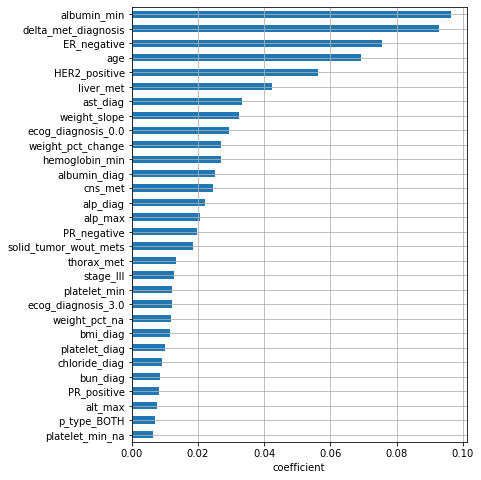

In [144]:
# Dataframe of coefficients for each variable 
coefficients_mice0 = pd.DataFrame(
    gbm_mice0.named_steps['gradientboostingsurvivalanalysis'].feature_importances_,
    index = attributes_gbm,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes_gbm)))

non_zero = np.sum(coefficients_mice0.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_mice0.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

In [145]:
coefficients_mice = (
    coefficients_mice0
    .reset_index()
    .rename(columns = {'index':'variable'}))

In [146]:
coefficients_mice.to_csv('coefficients_mice.csv', index = False, header = True)

### 3.2 Model 1

#### Preprocessing and building pipeline 

In [147]:
# Import second training set
train_mice1 = pd.read_csv('mice_tr1.csv', index_col = 'PatientID')

In [148]:
print(train_mice1.shape)

(25341, 183)


In [149]:
train_mice1.isna().sum().sum()

0

In [150]:
train_mice1 = train_mice1.drop(columns = mice_drop)

In [151]:
print(train_mice1.shape)
print(test_mice.shape)

(25341, 146)
(31680, 149)


In [152]:
train_mice1['ecog_na'] = np.where(train_mice1.index.isin(train.query('ecog_diagnosis == "unknown"').PatientID), 1, 0)
train_mice1['stage_na'] = np.where(train_mice1.index.isin(train.query('stage == "unknown"').PatientID), 1, 0)
train_mice1['ses_na'] = np.where(train_mice1.index.isin(train[train['ses'].isnull()].PatientID), 1, 0)

In [153]:
for x in list(to_be_categorical):
    train_mice1[x] = train_mice1[x].astype('category')
    
list(train_mice1.select_dtypes(include = ['category']).columns)

['gender',
 'race',
 'ethnicity',
 'p_type',
 'region',
 'stage',
 'met_year',
 'ER',
 'HER2',
 'PR',
 'BRCA',
 'PIK3CA',
 'pdl1_n',
 'ecog_diagnosis',
 'ses']

In [154]:
train_mice1['death_status'] = train_mice1['death_status'].astype('bool')

In [155]:
val_mice1 = train_mice1[train_mice1.index.isin(val_IDs['PatientID'])]

sub_train_mice1 = train_mice1[~train_mice1.index.isin(val_IDs['PatientID'])]

In [156]:
print(train_mice1.shape)
print(sub_train_mice1.shape)
print(val_mice1.shape)

(25341, 149)
(19005, 149)
(6336, 149)


In [157]:
train_mice1_x = train_mice1.drop(columns = ['death_status', 'timerisk_activity'])

sub_train_mice1_x = sub_train_mice1.drop(columns = ['death_status', 'timerisk_activity'])

val_mice1_x = val_mice1.drop(columns = ['death_status', 'timerisk_activity'])

In [158]:
print(train_mice1_x.shape)
print(sub_train_mice1_x.shape)
print(val_mice1_x.shape)

(25341, 147)
(19005, 147)
(6336, 147)


#### Hyperparameter tuning 

In [159]:
sub_train_mice1_xt = preprocessor_red.fit_transform(sub_train_mice1_x)
val_mice1_xt = preprocessor_red.transform(val_mice1_x)

gbm_mice1_exp = GradientBoostingSurvivalAnalysis(n_estimators = 2000,
                                                 learning_rate = 0.05,
                                                 max_depth = 2,
                                                 subsample = 0.75,
                                                 verbose = 1,
                                                 random_state = 42)

gbm_mice1_exp.fit(sub_train_mice1_xt, sub_train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       71498.1549           9.8431          206.74m
         2       71615.9197           8.8271          208.24m
         3       71462.9189           9.5814          208.50m
         4       71167.5465           8.9684          208.54m
         5       71508.7744           7.8459          208.42m
         6       71567.7867           7.6701          208.59m
         7       71263.5768           7.5187          208.76m
         8       71202.3565           7.2333          208.49m
         9       71350.8015           6.9419          208.27m
        10       71502.9351           6.5948          207.92m
        20       70429.7997           5.8325          205.67m
        30       70632.7268           4.0313          204.17m
        40       70451.8487           3.5235          202.85m
        50       70646.4193           2.9636          201.68m
        60       70551.3578           2.4345          200.51m
       

GradientBoostingSurvivalAnalysis(learning_rate=0.05, max_depth=2,
                                 n_estimators=2000, random_state=42,
                                 subsample=0.75, verbose=1)

In [160]:
gbm1_staged_auc = [cumulative_dynamic_auc(sub_train_y, val_y, risk_score, 730)[0][0] for 
                   risk_score in gbm_mice1_exp.staged_predict(val_mice1_xt)]

In [161]:
gbm1_staged_auc_tr = [cumulative_dynamic_auc(sub_train_y, sub_train_y, risk_score, 730)[0][0] for 
                      risk_score in gbm_mice1_exp.staged_predict(sub_train_mice1_xt)]

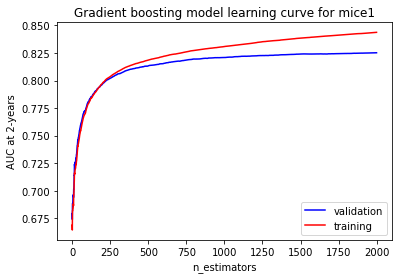

In [162]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = range(len(gbm1_staged_auc))
plt.plot(x, gbm1_staged_auc, color = 'blue', label = 'validation')
plt.plot(x, gbm1_staged_auc_tr, color = 'red', label = 'training')
plt.legend(loc = 'lower right')

plt.xlabel("n_estimators")
plt.ylabel("AUC at 2-years")
plt.title('Gradient boosting model learning curve for mice1')

plt.show()

In [163]:
# Average AUC for every 25 additional trees. 
mean_auc_list = []
for x in np.arange(0, len(gbm1_staged_auc), 25):
    mean_auc_list.append(np.mean(gbm1_staged_auc[x:x+24]))

In [164]:
print('Number of trees where 2 year AUC on validation dataset beings to downgrade:', np.where(np.diff(mean_auc_list) < 0)[0][0]*25)
print('Validation dataset AUC before degrading:', gbm1_staged_auc[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])
print('Training dataset AUC before degrading:', gbm1_staged_auc_tr[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])

Number of trees where 2 year AUC on validation dataset beings to downgrade: 1500
Validation dataset AUC before degrading: 0.8241001148543883
Training dataset AUC before degrading: 0.8385587231528568


#### Building model and assessing performance 

In [165]:
gbm_mice1 = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = np.where(np.diff(mean_auc_list) < 0)[0][0]*25,
                                                                             learning_rate = 0.05,
                                                                             max_depth = 2,
                                                                             subsample = 0.75,
                                                                             verbose = 1,
                                                                             random_state = 42))

gbm_mice1.fit(train_mice1_x, train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       98559.1210          13.9210          279.03m
         2       98553.0215          13.3963          279.19m
         3       99002.0576          12.3074          278.69m
         4       98605.5294          11.9085          278.97m
         5       98463.7019          11.0473          278.95m
         6       98145.6424          10.9081          278.93m
         7       98420.2561          11.0428          279.07m
         8       98508.9477           9.1538          279.20m
         9       98360.8676           9.2310          278.77m
        10       98571.0434           8.5401          278.43m
        20       98330.3900           6.0620          275.67m
        30       97798.1738           4.4919          273.59m
        40       97591.8060           5.1348          271.56m
        50       97658.7250           4.0691          269.64m
        60       97314.2980           4.2326          267.90m
       

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'delta_met_diagnosis',
                                                   'weight_diag', 'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                                                   'bicarb_diag', 'bun_diag',
                                                   'calcium_diag',
                                                   'chloride_diag',
           

In [166]:
dump(gbm_mice1, 'gbm_mice1.joblib') 

['gbm_mice1.joblib']

In [167]:
gbm_risk_scores_te = gbm_mice1.predict(test_mice_x)
gbm_auc_te = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, 730)[0][0]
print('Test set AUC at 2 years:', gbm_auc_te)

Test set AUC at 2 years: 0.8193993262612045


In [168]:
gbm_risk_scores_tr = gbm_mice1.predict(train_mice1_x)
gbm_auc_tr = cumulative_dynamic_auc(train_y, train_y, gbm_risk_scores_tr, 730)[0][0]
print('Training set AUC at 2 years:', gbm_auc_tr)

Training set AUC at 2 years: 0.8369366381232837


In [169]:
# Bootstrap 10000 1 yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_te), len(gbm_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], gbm_risk_scores_te[indices], 730)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [170]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.002712535029300578


In [171]:
# Bootstrap 10000 1-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_tr), len(gbm_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], gbm_risk_scores_tr[indices], 730)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [172]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.0028862425366678068


In [173]:
mice_auc_data = {'mice_dataset': 'mice_1',
                 'auc_2yr_te': gbm_auc_te,
                 'sem_te': standard_error_te,
                 'auc_2yr_tr': gbm_auc_tr,
                 'sem_tr': standard_error_tr}

mice_auc_df = mice_auc_df.append(mice_auc_data, ignore_index = True)

In [174]:
mice_auc_df 

,mice_dataset,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,mice_0,0.815912,0.002723,0.831202,0.002954
1,mice_1,0.819399,0.002713,0.836937,0.002886


In [175]:
mice_auc_df.to_csv('mice_auc_df.csv', index = False, header = True)

In [176]:
times = np.arange(30, 1810, 30)
mice1_auc_over5 = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, times)[0]

times_data = {}
values = mice1_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
mice1_auc_over5_df = pd.DataFrame(times_data, index = ['mice_1'])

mice_auc_over5 = mice_auc_over5.append(mice1_auc_over5_df, ignore_index = False)

In [177]:
mice_auc_over5 

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
mice_0,0.867587,0.872672,0.860214,0.859627,0.859415,0.849943,0.849662,0.848590,0.848488,0.847318,...,0.777097,0.774220,0.775240,0.77486,0.773773,0.772356,0.770324,0.768801,0.768946,0.768499
mice_1,0.869412,0.877509,0.864961,0.862955,0.862670,0.852643,0.852460,0.851871,0.852311,0.850812,...,0.781924,0.779365,0.780204,0.77994,0.778950,0.778269,0.776133,0.775179,0.775236,0.774991


In [178]:
mice_auc_over5.to_csv('mice_auc_over5.csv', index = True, header = True)

In [179]:
# Variables passing through pipeline_rsf
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_mice1_x.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes_gbm = numerical_features_red + cat_encoder + pass_through

Total number of features: 194
Number of non-zero features in final model: 142


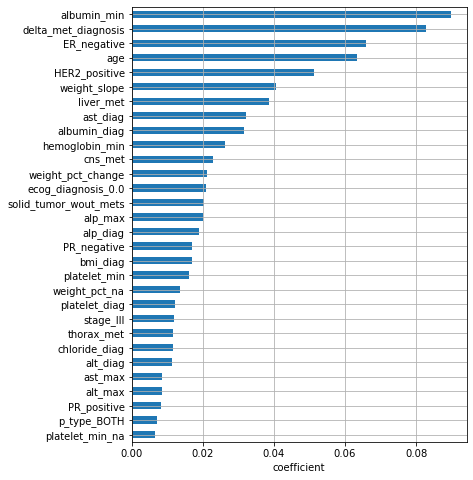

In [180]:
# Dataframe of coefficients for each variable 
coefficients_mice1 = pd.DataFrame(
    gbm_mice1.named_steps['gradientboostingsurvivalanalysis'].feature_importances_,
    index = attributes_gbm,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes_gbm)))

non_zero = np.sum(coefficients_mice1.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_mice1.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

In [181]:
coefficients_mice1_df = (
    coefficients_mice1
    .reset_index()
    .rename(columns = {'index':'variable'}))

In [182]:
coefficients_mice = coefficients_mice.append(coefficients_mice1_df, ignore_index = True)

In [183]:
coefficients_mice.to_csv('coefficients_mice.csv', index = False, header = True)

### 3.3 Model 3

#### Preprocessing 

In [184]:
train_mice2 = pd.read_csv('mice_tr2.csv', index_col = 'PatientID')

In [185]:
print(train_mice2.shape)

(25341, 183)


In [186]:
train_mice2.isna().sum().sum()

0

In [187]:
train_mice2 = train_mice2.drop(columns = mice_drop)

In [188]:
print(train_mice2.shape)

(25341, 146)


In [189]:
train_mice2['ecog_na'] = np.where(train_mice2.index.isin(train.query('ecog_diagnosis == "unknown"').PatientID), 1, 0)
train_mice2['stage_na'] = np.where(train_mice2.index.isin(train.query('stage == "unknown"').PatientID), 1, 0)
train_mice2['ses_na'] = np.where(train_mice2.index.isin(train[train['ses'].isnull()].PatientID), 1, 0)

In [190]:
for x in list(to_be_categorical):
    train_mice2[x] = train_mice2[x].astype('category')
    
list(train_mice2.select_dtypes(include = ['category']).columns)

['gender',
 'race',
 'ethnicity',
 'p_type',
 'region',
 'stage',
 'met_year',
 'ER',
 'HER2',
 'PR',
 'BRCA',
 'PIK3CA',
 'pdl1_n',
 'ecog_diagnosis',
 'ses']

In [191]:
train_mice2['death_status'] = train_mice2['death_status'].astype('bool')

In [192]:
val_mice2 = train_mice2[train_mice2.index.isin(val_IDs['PatientID'])]

sub_train_mice2 = train_mice2[~train_mice2.index.isin(val_IDs['PatientID'])]

In [193]:
print(train_mice2.shape)
print(sub_train_mice2.shape)
print(val_mice2.shape)

(25341, 149)
(19005, 149)
(6336, 149)


In [194]:
train_mice2_x = train_mice2.drop(columns = ['death_status', 'timerisk_activity'])

sub_train_mice2_x = sub_train_mice2.drop(columns = ['death_status', 'timerisk_activity'])

val_mice2_x = val_mice2.drop(columns = ['death_status', 'timerisk_activity'])

In [195]:
print(train_mice2_x.shape)
print(sub_train_mice2_x.shape)
print(val_mice2_x.shape)

(25341, 147)
(19005, 147)
(6336, 147)


#### Hyperparameter tuning 

In [196]:
sub_train_mice2_xt = preprocessor_red.fit_transform(sub_train_mice2_x)
val_mice2_xt = preprocessor_red.transform(val_mice2_x)

gbm_mice2_exp = GradientBoostingSurvivalAnalysis(n_estimators = 2000,
                                                 learning_rate = 0.05,
                                                 max_depth = 2,
                                                 subsample = 0.75,
                                                 verbose = 1,
                                                 random_state = 42)

gbm_mice2_exp.fit(sub_train_mice2_xt, sub_train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       71499.8033           8.9616          206.96m
         2       71619.8383           8.3827          206.70m
         3       71468.1389           8.5675          206.60m
         4       71172.1129           7.9324          206.58m
         5       71517.2732           7.1386          206.47m
         6       71575.6872           8.6636          206.79m
         7       71274.0926           7.1552          206.62m
         8       71210.0473           6.5292          206.46m
         9       71363.4598           6.6786          206.35m
        10       71516.6451           6.2915          206.15m
        20       70440.6676           4.9336          205.06m
        30       70640.6966           4.2377          203.94m
        40       70472.2727           3.4541          202.89m
        50       70658.7720           2.7139          201.82m
        60       70563.3022           2.7426          200.75m
       

GradientBoostingSurvivalAnalysis(learning_rate=0.05, max_depth=2,
                                 n_estimators=2000, random_state=42,
                                 subsample=0.75, verbose=1)

In [197]:
gbm2_staged_auc = [cumulative_dynamic_auc(sub_train_y, val_y, risk_score, 730)[0][0] for 
                   risk_score in gbm_mice2_exp.staged_predict(val_mice2_xt)]

In [198]:
gbm2_staged_auc_tr = [cumulative_dynamic_auc(sub_train_y, sub_train_y, risk_score, 730)[0][0] for 
                      risk_score in gbm_mice2_exp.staged_predict(sub_train_mice2_xt)]

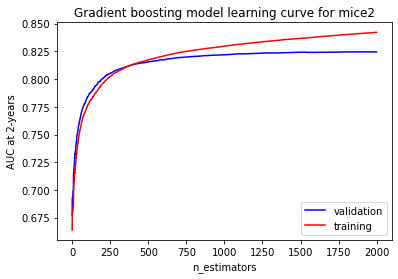

In [199]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = range(len(gbm2_staged_auc))
plt.plot(x, gbm2_staged_auc, color = 'blue', label = 'validation')
plt.plot(x, gbm2_staged_auc_tr, color = 'red', label = 'training')
plt.legend(loc = 'lower right')

plt.xlabel("n_estimators")
plt.ylabel("AUC at 2-years")
plt.title('Gradient boosting model learning curve for mice2')

plt.show()

In [200]:
# Average AUC for every 25 additional trees. 
mean_auc_list = []
for x in np.arange(0, len(gbm2_staged_auc), 25):
    mean_auc_list.append(np.mean(gbm2_staged_auc[x:x+24]))

In [201]:
print('Number of trees where 2 year AUC on validation dataset beings to downgrade:', np.where(np.diff(mean_auc_list) < 0)[0][0]*25)
print('Validation dataset AUC before degrading:', gbm2_staged_auc[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])
print('Training dataset AUC before degrading:', gbm2_staged_auc_tr[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])

Number of trees where 2 year AUC on validation dataset beings to downgrade: 1275
Validation dataset AUC before degrading: 0.823615613632476
Training dataset AUC before degrading: 0.8340136530273987


#### Building model and assessing performance

In [202]:
gbm_mice2 = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = np.where(np.diff(mean_auc_list) < 0)[0][0]*25,
                                                                             learning_rate = 0.05,
                                                                             max_depth = 2,
                                                                             subsample = 0.75,
                                                                             verbose = 1,
                                                                             random_state = 42))

gbm_mice2.fit(train_mice2_x, train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       98562.7972          13.0512          236.66m
         2       98558.6131          12.5279          236.65m
         3       99011.5748          11.0802          236.35m
         4       98614.5677          11.2149          236.09m
         5       98475.8414          10.4162          235.86m
         6       98159.7539          10.1958          235.67m
         7       98435.8701          10.2524          235.50m
         8       98527.6236           8.6725          235.26m
         9       98380.0786           8.6977          235.09m
        10       98594.7440           8.6817          234.91m
        20       98348.5954           7.1594          233.03m
        30       97822.8465           5.7259          231.20m
        40       97611.4516           7.1961          229.53m
        50       97679.7675           4.0748          227.66m
        60       97326.8657           4.6938          225.78m
       

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'delta_met_diagnosis',
                                                   'weight_diag', 'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                                                   'bicarb_diag', 'bun_diag',
                                                   'calcium_diag',
                                                   'chloride_diag',
           

In [203]:
dump(gbm_mice2, 'gbm_mice2.joblib') 

['gbm_mice2.joblib']

In [204]:
gbm_risk_scores_te = gbm_mice2.predict(test_mice_x)
gbm_auc_te = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, 730)[0][0]
print('Test set AUC at 2 year:', gbm_auc_te)

Test set AUC at 2 year: 0.8173546935080371


In [205]:
gbm_risk_scores_tr = gbm_mice2.predict(train_mice2_x)
gbm_auc_tr = cumulative_dynamic_auc(train_y, train_y, gbm_risk_scores_tr, 730)[0][0]
print('Training set AUC at 2 year:', gbm_auc_tr)

Training set AUC at 2 year: 0.8328191177728871


In [206]:
# Bootstrap 10000 1 yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_te), len(gbm_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], gbm_risk_scores_te[indices], 730)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [207]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.00270809917995245


In [208]:
# Bootstrap 10000 1-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_tr), len(gbm_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], gbm_risk_scores_tr[indices], 730)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [209]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.0029308329006440853


In [210]:
mice_auc_data = {'mice_dataset': 'mice_2',
                 'auc_2yr_te': gbm_auc_te,
                 'sem_te': standard_error_te,
                 'auc_2yr_tr': gbm_auc_tr,
                 'sem_tr': standard_error_tr}

mice_auc_df = mice_auc_df.append(mice_auc_data, ignore_index = True)

In [211]:
mice_auc_df 

,mice_dataset,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,mice_0,0.815912,0.002723,0.831202,0.002954
1,mice_1,0.819399,0.002713,0.836937,0.002886
2,mice_2,0.817355,0.002708,0.832819,0.002931


In [212]:
mice_auc_df.to_csv('mice_auc_df.csv', index = False, header = True)

In [213]:
times = np.arange(30, 1810, 30)
mice2_auc_over5 = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, times)[0]

times_data = {}
values = mice2_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
mice2_auc_over5_df = pd.DataFrame(times_data, index = ['mice_2'])

mice_auc_over5 = mice_auc_over5.append(mice2_auc_over5_df, ignore_index = False)

In [214]:
mice_auc_over5

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
mice_0,0.867587,0.872672,0.860214,0.859627,0.859415,0.849943,0.849662,0.848590,0.848488,0.847318,...,0.777097,0.774220,0.775240,0.774860,0.773773,0.772356,0.770324,0.768801,0.768946,0.768499
mice_1,0.869412,0.877509,0.864961,0.862955,0.862670,0.852643,0.852460,0.851871,0.852311,0.850812,...,0.781924,0.779365,0.780204,0.779940,0.778950,0.778269,0.776133,0.775179,0.775236,0.774991
mice_2,0.863310,0.871853,0.861056,0.860159,0.860275,0.852383,0.852393,0.851538,0.851889,0.850479,...,0.780736,0.778018,0.779104,0.778733,0.777798,0.776629,0.774787,0.773729,0.774207,0.773760


In [215]:
mice_auc_over5.to_csv('mice_auc_over5.csv', index = True, header = True)

In [216]:
# Variables passing through pipeline_rsf
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_mice2_x.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes_gbm = numerical_features_red + cat_encoder + pass_through

Total number of features: 194
Number of non-zero features in final model: 136


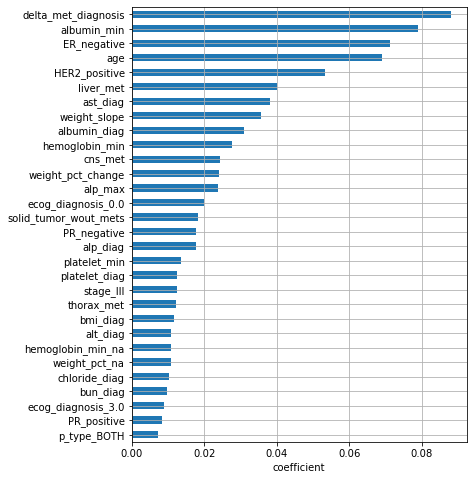

In [217]:
# Dataframe of coefficients for each variable 
coefficients_mice2 = pd.DataFrame(
    gbm_mice2.named_steps['gradientboostingsurvivalanalysis'].feature_importances_,
    index = attributes_gbm,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes_gbm)))

non_zero = np.sum(coefficients_mice2.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_mice2.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

In [218]:
coefficients_mice2_df = (
    coefficients_mice2
    .reset_index()
    .rename(columns = {'index':'variable'}))

In [219]:
coefficients_mice = coefficients_mice.append(coefficients_mice2_df, ignore_index = True)

In [220]:
coefficients_mice.to_csv('coefficients_mice.csv', index = False, header = True)

### 3.4 Model 4

#### Preprocessing 

In [221]:
train_mice3 = pd.read_csv('mice_tr3.csv', index_col = 'PatientID')

In [222]:
print(train_mice3.shape)

(25341, 183)


In [223]:
train_mice3.isna().sum().sum()

0

In [224]:
train_mice3 = train_mice3.drop(columns = mice_drop)

In [225]:
print(train_mice3.shape)

(25341, 146)


In [226]:
train_mice3['ecog_na'] = np.where(train_mice3.index.isin(train.query('ecog_diagnosis == "unknown"').PatientID), 1, 0)
train_mice3['stage_na'] = np.where(train_mice3.index.isin(train.query('stage == "unknown"').PatientID), 1, 0)
train_mice3['ses_na'] = np.where(train_mice3.index.isin(train[train['ses'].isnull()].PatientID), 1, 0)

In [227]:
for x in list(to_be_categorical):
    train_mice3[x] = train_mice3[x].astype('category')
    
list(train_mice3.select_dtypes(include = ['category']).columns)

['gender',
 'race',
 'ethnicity',
 'p_type',
 'region',
 'stage',
 'met_year',
 'ER',
 'HER2',
 'PR',
 'BRCA',
 'PIK3CA',
 'pdl1_n',
 'ecog_diagnosis',
 'ses']

In [228]:
train_mice3['death_status'] = train_mice3['death_status'].astype('bool')

In [229]:
val_mice3 = train_mice3[train_mice3.index.isin(val_IDs['PatientID'])]

sub_train_mice3 = train_mice3[~train_mice3.index.isin(val_IDs['PatientID'])]

In [230]:
print(train_mice3.shape)
print(sub_train_mice3.shape)
print(val_mice3.shape)

(25341, 149)
(19005, 149)
(6336, 149)


In [231]:
train_mice3_x = train_mice3.drop(columns = ['death_status', 'timerisk_activity'])

sub_train_mice3_x = sub_train_mice3.drop(columns = ['death_status', 'timerisk_activity'])

val_mice3_x = val_mice3.drop(columns = ['death_status', 'timerisk_activity'])

In [232]:
print(train_mice3_x.shape)
print(sub_train_mice3_x.shape)
print(val_mice3_x.shape)

(25341, 147)
(19005, 147)
(6336, 147)


#### Hyperparameter tuning 

In [233]:
sub_train_mice3_xt = preprocessor_red.fit_transform(sub_train_mice3_x)
val_mice3_xt = preprocessor_red.transform(val_mice3_x)

gbm_mice3_exp = GradientBoostingSurvivalAnalysis(n_estimators = 2000,
                                                 learning_rate = 0.05,
                                                 max_depth = 2,
                                                 subsample = 0.75,
                                                 verbose = 1,
                                                 random_state = 42)

gbm_mice3_exp.fit(sub_train_mice3_xt, sub_train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       71499.4376           9.5750          206.69m
         2       71617.6692           8.8745          208.39m
         3       71465.3737           9.0426          208.22m
         4       71170.3272           8.3793          207.68m
         5       71516.2039           7.7200          207.17m
         6       71574.2870           6.9534          206.74m
         7       71272.5489           6.9664          206.52m
         8       71207.5157           6.6488          206.32m
         9       71360.5897           6.6000          206.13m
        10       71512.8106           6.0522          205.93m
        20       70442.8855           4.6993          204.70m
        30       70638.0077           4.3520          203.46m
        40       70475.9346           3.7034          202.35m
        50       70665.7685           3.0441          201.29m
        60       70577.5488           2.6097          200.22m
       

GradientBoostingSurvivalAnalysis(learning_rate=0.05, max_depth=2,
                                 n_estimators=2000, random_state=42,
                                 subsample=0.75, verbose=1)

In [234]:
gbm3_staged_auc = [cumulative_dynamic_auc(sub_train_y, val_y, risk_score, 730)[0][0] for 
                   risk_score in gbm_mice3_exp.staged_predict(val_mice3_xt)]

In [235]:
gbm3_staged_auc_tr = [cumulative_dynamic_auc(sub_train_y, sub_train_y, risk_score, 730)[0][0] for 
                      risk_score in gbm_mice3_exp.staged_predict(sub_train_mice3_xt)]

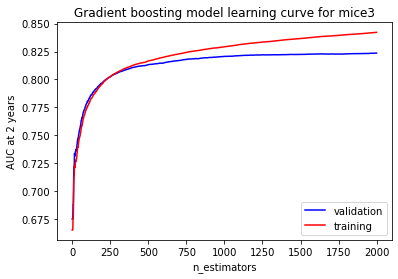

In [236]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = range(len(gbm3_staged_auc))
plt.plot(x, gbm3_staged_auc, color = 'blue', label = 'validation')
plt.plot(x, gbm3_staged_auc_tr, color = 'red', label = 'training')
plt.legend(loc = 'lower right')

plt.xlabel("n_estimators")
plt.ylabel("AUC at 2 years")
plt.title('Gradient boosting model learning curve for mice3')

plt.show()

In [237]:
# Average AUC for every 25 additional trees. 
mean_auc_list = []
for x in np.arange(0, len(gbm3_staged_auc), 25):
    mean_auc_list.append(np.mean(gbm3_staged_auc[x:x+24]))

In [238]:
print('Number of trees where 2 year AUC on validation dataset beings to downgrade:', np.where(np.diff(mean_auc_list) < 0)[0][0]*25)
print('Validation dataset AUC before degrading:', gbm3_staged_auc[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])
print('Training dataset AUC before degrading:', gbm3_staged_auc_tr[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])

Number of trees where 2 year AUC on validation dataset beings to downgrade: 1625
Validation dataset AUC before degrading: 0.82273941311324
Training dataset AUC before degrading: 0.8382124691920787


#### Model building and performance assessment 

In [239]:
gbm_mice3 = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = np.where(np.diff(mean_auc_list) < 0)[0][0]*25,
                                                                             learning_rate = 0.05,
                                                                             max_depth = 2,
                                                                             subsample = 0.75,
                                                                             verbose = 1,
                                                                             random_state = 42))

gbm_mice3.fit(train_mice3_x, train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       98561.0814          13.5631          301.93m
         2       98554.4055          13.0350          302.86m
         3       99005.1989          11.7205          302.43m
         4       98607.1928          11.3526          302.14m
         5       98467.6451          10.4948          301.88m
         6       98151.7186          10.3436          301.61m
         7       98428.3974          10.7523          301.48m
         8       98519.3443           8.7990          301.30m
         9       98367.6109           8.3113          301.07m
        10       98581.8405           8.6896          300.90m
        20       98334.1164           6.0941          299.06m
        30       97809.7779           5.7527          296.81m
        40       97602.5803           6.8166          295.06m
        50       97669.6545           3.9819          293.25m
        60       97327.4454           4.7582          291.43m
       

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'delta_met_diagnosis',
                                                   'weight_diag', 'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                                                   'bicarb_diag', 'bun_diag',
                                                   'calcium_diag',
                                                   'chloride_diag',
           

In [240]:
dump(gbm_mice3, 'gbm_mice3.joblib') 

['gbm_mice3.joblib']

In [241]:
gbm_risk_scores_te = gbm_mice3.predict(test_mice_x)
gbm_auc_te = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, 730)[0][0]
print('Test set AUC at 2 years:', gbm_auc_te)

Test set AUC at 2 years: 0.8198573927896737


In [242]:
gbm_risk_scores_tr = gbm_mice3.predict(train_mice3_x)
gbm_auc_tr = cumulative_dynamic_auc(train_y, train_y, gbm_risk_scores_tr, 730)[0][0]
print('Training set AUC at 2 years:', gbm_auc_tr)

Training set AUC at 2 years: 0.8371858811245254


In [243]:
# Bootstrap 10000 1 yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_te), len(gbm_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], gbm_risk_scores_te[indices], 730)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [244]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.0027277612305045256


In [245]:
# Bootstrap 10000 1-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_tr), len(gbm_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], gbm_risk_scores_tr[indices], 730)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [246]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.0028965568528312425


In [247]:
mice_auc_data = {'mice_dataset': 'mice_3',
                 'auc_2yr_te': gbm_auc_te,
                 'sem_te': standard_error_te,
                 'auc_2yr_tr': gbm_auc_tr,
                 'sem_tr': standard_error_tr}

mice_auc_df = mice_auc_df.append(mice_auc_data, ignore_index = True)

In [248]:
mice_auc_df 

,mice_dataset,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,mice_0,0.815912,0.002723,0.831202,0.002954
1,mice_1,0.819399,0.002713,0.836937,0.002886
2,mice_2,0.817355,0.002708,0.832819,0.002931
3,mice_3,0.819857,0.002728,0.837186,0.002897


In [249]:
mice_auc_df.to_csv('mice_auc_df.csv', index = False, header = True)

In [250]:
times = np.arange(30, 1810, 30)
mice3_auc_over5 = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, times)[0]

times_data = {}
values = mice3_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
mice3_auc_over5_df = pd.DataFrame(times_data, index = ['mice_3'])

mice_auc_over5 = mice_auc_over5.append(mice3_auc_over5_df, ignore_index = False)

In [251]:
mice_auc_over5

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
mice_0,0.867587,0.872672,0.860214,0.859627,0.859415,0.849943,0.849662,0.848590,0.848488,0.847318,...,0.777097,0.774220,0.775240,0.774860,0.773773,0.772356,0.770324,0.768801,0.768946,0.768499
mice_1,0.869412,0.877509,0.864961,0.862955,0.862670,0.852643,0.852460,0.851871,0.852311,0.850812,...,0.781924,0.779365,0.780204,0.779940,0.778950,0.778269,0.776133,0.775179,0.775236,0.774991
mice_2,0.863310,0.871853,0.861056,0.860159,0.860275,0.852383,0.852393,0.851538,0.851889,0.850479,...,0.780736,0.778018,0.779104,0.778733,0.777798,0.776629,0.774787,0.773729,0.774207,0.773760
mice_3,0.873606,0.878988,0.866900,0.865086,0.864979,0.855680,0.855088,0.854248,0.854045,0.852999,...,0.781202,0.778581,0.779250,0.779071,0.778181,0.777203,0.775131,0.773994,0.774257,0.774276


In [252]:
mice_auc_over5.to_csv('mice_auc_over5.csv', index = True, header = True)

In [253]:
# Variables passing through pipeline_rsf
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_mice3_x.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes_gbm = numerical_features_red + cat_encoder + pass_through

Total number of features: 194
Number of non-zero features in final model: 154


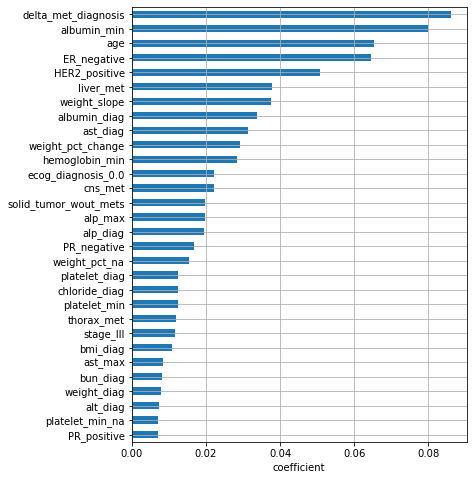

In [254]:
# Dataframe of coefficients for each variable 
coefficients_mice3 = pd.DataFrame(
    gbm_mice3.named_steps['gradientboostingsurvivalanalysis'].feature_importances_,
    index = attributes_gbm,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes_gbm)))

non_zero = np.sum(coefficients_mice3.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_mice3.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

In [255]:
coefficients_mice3_df = (
    coefficients_mice3
    .reset_index()
    .rename(columns = {'index':'variable'}))

In [256]:
coefficients_mice = coefficients_mice.append(coefficients_mice3_df, ignore_index = True)

In [257]:
coefficients_mice.to_csv('coefficients_mice.csv', index = False, header = True)

### 3.5 Model 5

#### Preprocessing

In [258]:
train_mice4 = pd.read_csv('mice_tr4.csv', index_col = 'PatientID')

In [259]:
train_mice4.shape

(25341, 183)

In [260]:
train_mice4.isna().sum().sum()

0

In [261]:
train_mice4 = train_mice4.drop(columns = mice_drop)

In [262]:
print(train_mice4.shape)

(25341, 146)


In [263]:
train_mice4['ecog_na'] = np.where(train_mice4.index.isin(train.query('ecog_diagnosis == "unknown"').PatientID), 1, 0)
train_mice4['stage_na'] = np.where(train_mice4.index.isin(train.query('stage == "unknown"').PatientID), 1, 0)
train_mice4['ses_na'] = np.where(train_mice4.index.isin(train[train['ses'].isnull()].PatientID), 1, 0)

In [264]:
for x in list(to_be_categorical):
    train_mice4[x] = train_mice4[x].astype('category')
    
list(train_mice4.select_dtypes(include = ['category']).columns)

['gender',
 'race',
 'ethnicity',
 'p_type',
 'region',
 'stage',
 'met_year',
 'ER',
 'HER2',
 'PR',
 'BRCA',
 'PIK3CA',
 'pdl1_n',
 'ecog_diagnosis',
 'ses']

In [265]:
train_mice4['death_status'] = train_mice4['death_status'].astype('bool')

In [266]:
val_mice4 = train_mice4[train_mice4.index.isin(val_IDs['PatientID'])]

sub_train_mice4 = train_mice4[~train_mice4.index.isin(val_IDs['PatientID'])]

In [267]:
print(train_mice4.shape)
print(sub_train_mice4.shape)
print(val_mice4.shape)

(25341, 149)
(19005, 149)
(6336, 149)


In [268]:
train_mice4_x = train_mice4.drop(columns = ['death_status', 'timerisk_activity'])

sub_train_mice4_x = sub_train_mice4.drop(columns = ['death_status', 'timerisk_activity'])

val_mice4_x = val_mice4.drop(columns = ['death_status', 'timerisk_activity'])

In [269]:
print(train_mice4_x.shape)
print(sub_train_mice4_x.shape)
print(val_mice4_x.shape)

(25341, 147)
(19005, 147)
(6336, 147)


#### Hyperparameter tuning

In [270]:
sub_train_mice4_xt = preprocessor_red.fit_transform(sub_train_mice4_x)
val_mice4_xt = preprocessor_red.transform(val_mice4_x)

gbm_mice4_exp = GradientBoostingSurvivalAnalysis(n_estimators = 2000,
                                                 learning_rate = 0.05,
                                                 max_depth = 2,
                                                 subsample = 0.75,
                                                 verbose = 1,
                                                 random_state = 42)

gbm_mice4_exp.fit(sub_train_mice4_xt, sub_train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       71498.8462           9.3123          207.17m
         2       71618.1137           9.0636          207.03m
         3       71464.9766           8.8759          206.88m
         4       71167.9448           8.1020          206.80m
         5       71514.0978           7.7733          206.95m
         6       71572.4368           7.3209          206.76m
         7       71269.3617           7.1944          206.67m
         8       71206.4270           6.8380          206.57m
         9       71355.8682           6.4092          206.48m
        10       71509.5614           6.5898          206.28m
        20       70432.0910           4.9643          205.06m
        30       70639.1433           4.3341          204.00m
        40       70456.4817           3.5783          202.90m
        50       70650.3423           2.9737          201.84m
        60       70561.2949           2.6143          200.75m
       

GradientBoostingSurvivalAnalysis(learning_rate=0.05, max_depth=2,
                                 n_estimators=2000, random_state=42,
                                 subsample=0.75, verbose=1)

In [271]:
gbm4_staged_auc = [cumulative_dynamic_auc(sub_train_y, val_y, risk_score, 730)[0][0] for 
                   risk_score in gbm_mice4_exp.staged_predict(val_mice4_xt)]

In [272]:
gbm4_staged_auc_tr = [cumulative_dynamic_auc(sub_train_y, sub_train_y, risk_score, 730)[0][0] for 
                      risk_score in gbm_mice4_exp.staged_predict(sub_train_mice4_xt)]

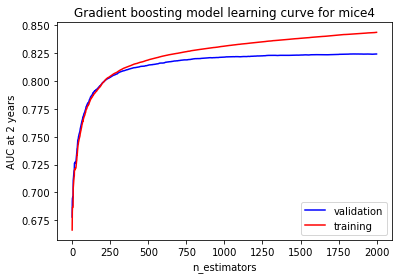

In [273]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = range(len(gbm4_staged_auc))
plt.plot(x, gbm4_staged_auc, color = 'blue', label = 'validation')
plt.plot(x, gbm4_staged_auc_tr, color = 'red', label = 'training')
plt.legend(loc = 'lower right')

plt.xlabel("n_estimators")
plt.ylabel("AUC at 2 years")
plt.title('Gradient boosting model learning curve for mice4')

plt.show()

In [274]:
# Average AUC for every 25 additional trees. 
mean_auc_list = []
for x in np.arange(0, len(gbm4_staged_auc), 25):
    mean_auc_list.append(np.mean(gbm4_staged_auc[x:x+24]))

In [275]:
print('Number of trees where 2 year AUC on validation dataset beings to downgrade:', np.where(np.diff(mean_auc_list) < 0)[0][0]*25)
print('Validation dataset AUC before degrading:', gbm4_staged_auc[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])
print('Training dataset AUC before degrading:', gbm4_staged_auc_tr[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])

Number of trees where 2 year AUC on validation dataset beings to downgrade: 1375
Validation dataset AUC before degrading: 0.8231200043668183
Training dataset AUC before degrading: 0.8369727188503097


#### Model building and performance asssessment 

In [276]:
print(train_mice4_x.shape)
print(train_y.shape)

(25341, 147)
(25341,)


In [277]:
gbm_mice4 = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = np.where(np.diff(mean_auc_list) < 0)[0][0]*25,
                                                                             learning_rate = 0.05,
                                                                             max_depth = 2,
                                                                             subsample = 0.75,
                                                                             verbose = 1,
                                                                             random_state = 42))

gbm_mice4.fit(train_mice4_x, train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       98561.1067          13.5258          255.22m
         2       98555.6940          12.8520          255.24m
         3       99007.8238          11.6907          255.50m
         4       98611.2316          11.4066          255.32m
         5       98470.2265          10.5005          255.17m
         6       98154.9551          10.7354          255.00m
         7       98431.3349          10.6051          254.82m
         8       98517.4671           8.7082          254.63m
         9       98368.5912           8.7495          254.46m
        10       98583.7267           8.7502          254.31m
        20       98337.6527           5.9459          252.37m
        30       97803.9897           5.4607          250.54m
        40       97612.7931           4.9922          248.68m
        50       97676.0241           3.7590          246.80m
        60       97323.0979           4.6773          244.94m
       

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'delta_met_diagnosis',
                                                   'weight_diag', 'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                                                   'bicarb_diag', 'bun_diag',
                                                   'calcium_diag',
                                                   'chloride_diag',
           

In [278]:
dump(gbm_mice4, 'gbm_mice4.joblib') 

['gbm_mice4.joblib']

In [279]:
gbm_risk_scores_te = gbm_mice4.predict(test_mice_x)
gbm_auc_te = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, 730)[0][0]
print('Test set AUC at 2 years:', gbm_auc_te)

Test set AUC at 2 years: 0.8188263869242295


In [280]:
gbm_risk_scores_tr = gbm_mice4.predict(train_mice4_x)
gbm_auc_tr = cumulative_dynamic_auc(train_y, train_y, gbm_risk_scores_tr, 730)[0][0]
print('Training set AUC at 2 years:', gbm_auc_tr)

Training set AUC at 2 years: 0.8360363482393084


In [281]:
# Bootstrap 10000 2 yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_te), len(gbm_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], gbm_risk_scores_te[indices], 730)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [282]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.0027135724561940903


In [283]:
# Bootstrap 10000 2 yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_tr), len(gbm_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], gbm_risk_scores_tr[indices], 730)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [284]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.002894437520095689


In [285]:
mice_auc_data = {'mice_dataset': 'mice_4',
                 'auc_2yr_te': gbm_auc_te,
                 'sem_te': standard_error_te,
                 'auc_2yr_tr': gbm_auc_tr,
                 'sem_tr': standard_error_tr}

mice_auc_df = mice_auc_df.append(mice_auc_data, ignore_index = True)

In [286]:
mice_auc_df 

,mice_dataset,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,mice_0,0.815912,0.002723,0.831202,0.002954
1,mice_1,0.819399,0.002713,0.836937,0.002886
2,mice_2,0.817355,0.002708,0.832819,0.002931
3,mice_3,0.819857,0.002728,0.837186,0.002897
4,mice_4,0.818826,0.002714,0.836036,0.002894


In [287]:
mice_auc_df.to_csv('mice_auc_df.csv', index = False, header = True)

In [288]:
times = np.arange(30, 1810, 30)
mice4_auc_over5 = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, times)[0]

times_data = {}
values = mice4_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
mice4_auc_over5_df = pd.DataFrame(times_data, index = ['mice_4'])

mice_auc_over5 = mice_auc_over5.append(mice4_auc_over5_df, ignore_index = False)

In [289]:
mice_auc_over5 

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
mice_0,0.867587,0.872672,0.860214,0.859627,0.859415,0.849943,0.849662,0.848590,0.848488,0.847318,...,0.777097,0.774220,0.775240,0.774860,0.773773,0.772356,0.770324,0.768801,0.768946,0.768499
mice_1,0.869412,0.877509,0.864961,0.862955,0.862670,0.852643,0.852460,0.851871,0.852311,0.850812,...,0.781924,0.779365,0.780204,0.779940,0.778950,0.778269,0.776133,0.775179,0.775236,0.774991
mice_2,0.863310,0.871853,0.861056,0.860159,0.860275,0.852383,0.852393,0.851538,0.851889,0.850479,...,0.780736,0.778018,0.779104,0.778733,0.777798,0.776629,0.774787,0.773729,0.774207,0.773760
mice_3,0.873606,0.878988,0.866900,0.865086,0.864979,0.855680,0.855088,0.854248,0.854045,0.852999,...,0.781202,0.778581,0.779250,0.779071,0.778181,0.777203,0.775131,0.773994,0.774257,0.774276
mice_4,0.867245,0.874193,0.861777,0.861495,0.861096,0.851461,0.851680,0.850552,0.850692,0.849395,...,0.781181,0.778388,0.779223,0.778941,0.777926,0.776825,0.774835,0.773783,0.774002,0.773737


In [290]:
mice_auc_over5.to_csv('mice_auc_over5.csv', index = True, header = True)

In [291]:
# Variables passing through pipeline_rsf
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_mice4_x.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes_gbm = numerical_features_red + cat_encoder + pass_through

Total number of features: 194
Number of non-zero features in final model: 145


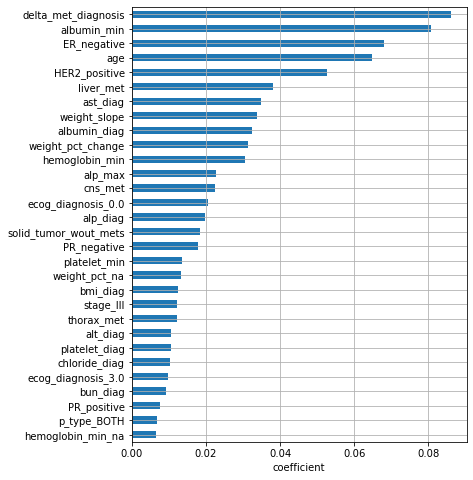

In [292]:
# Dataframe of coefficients for each variable 
coefficients_mice4 = pd.DataFrame(
    gbm_mice4.named_steps['gradientboostingsurvivalanalysis'].feature_importances_,
    index = attributes_gbm,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes_gbm)))

non_zero = np.sum(coefficients_mice4.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_mice4.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

In [293]:
coefficients_mice4_df = (
    coefficients_mice4
    .reset_index()
    .rename(columns = {'index':'variable'}))

In [294]:
coefficients_mice = coefficients_mice.append(coefficients_mice4_df, ignore_index = True)

In [295]:
coefficients_mice.to_csv('coefficients_mice.csv', index = False, header = True)

### Part 4. Pooling results

#### 4.1 Pooling AUC

In [296]:
from math import sqrt, exp 
from scipy.stats import t

**Test and training AUCs will be pooled using Rubin’s rules. This is complicated by the fact that AUCs are bounded and thus not normally distributed. The AUCs will therefore be logit transformed to an unbounded scale, then Rubin's rules will be applied to these values, and finally they will be back-transformed into a final pool estimate.** 

In [297]:
# This function is translated from the R package: "psfmi: Prediction Model Selection and Performance Evaluation in
# Multiple Imputed Datasets"

def pool_auc(auc_arr, se_arr, iterations_n):
    
    # pooled SE using Rubin's rules 
    def rr_se(est, se, iterations_n):
        m = iterations_n
        w_auc = np.mean(np.square(se)) # within variance 
        b_auc = np.var(est) # between variance 
        tv_auc = w_auc + (1 + (1/m)) * b_auc # total vairance 
        se_total = sqrt(tv_auc)
        r = (1 + (1/ m)) * (b_auc / w_auc)
        v = (m - 1) * (1 + (1/r))**2
        w = t.ppf(0.975, v) # Percent point function or inverse CDF with df = v
        res = np.array([se_total, w])
        return(res)
    
    # log transform
    auc_log = np.log(auc_arr / (1-auc_arr))
    se_log = se_arr / (auc_arr * (1-auc_arr))
    
    # input log transfomred auc and se to calculat RR's total se
    se_total = rr_se(auc_log, se_log, iterations_n = iterations_n)
    
    # backtransform 
    inv_auc = exp(np.mean(auc_log)) / (1 + exp(np.mean(auc_log)))
    inv_auc_upper = exp(np.mean(auc_log) + (se_total[1]*se_total[0])) / (1 + exp(np.mean(auc_log) + (se_total[1]*se_total[0])))
    inv_auc_lower = exp(np.mean(auc_log) - (se_total[1]*se_total[0])) / (1 + exp(np.mean(auc_log) - (se_total[1]*se_total[0])))
    sem = (inv_auc_upper - inv_auc_lower) / 3.92
    auc_res = np.round(np.array([inv_auc_lower, inv_auc, inv_auc_upper, sem]), 6)
    return(auc_res)

In [298]:
mice_auc_df = pd.read_csv('mice_auc_df.csv', dtype = {'auc_2yr_te': np.float64,
                                                      'sem_te': np.float64,
                                                      'auc_2yr_tr': np.float64,
                                                      'sem_tr': np.float64})

In [299]:
mice_auc_df

,mice_dataset,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,mice_0,0.815912,0.002723,0.831202,0.002954
1,mice_1,0.819399,0.002713,0.836937,0.002886
2,mice_2,0.817355,0.002708,0.832819,0.002931
3,mice_3,0.819857,0.002728,0.837186,0.002897
4,mice_4,0.818826,0.002714,0.836036,0.002894


In [300]:
pool_auc_test = pool_auc(mice_auc_df['auc_2yr_te'].values, 
                         mice_auc_df['sem_te'].values, 
                         5)

print(pool_auc_test)

[0.811902 0.818274 0.824478 0.003208]


In [301]:
pool_auc_train = pool_auc(mice_auc_df['auc_2yr_tr'].values,
                          mice_auc_df['sem_tr'].values,
                          5)

print(pool_auc_train)

[0.826524 0.83485  0.842852 0.004165]


In [302]:
crude_auc_df = pd.read_csv('crude_auc_df.csv', dtype = {'auc_2yr_te': np.float64,
                                                        'sem_te': np.float64,
                                                        'auc_2yr_tr': np.float64,
                                                        'sem_tr': np.float64})

In [303]:
crude_auc_df

,model,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,gbm_crude,0.817707,0.005979,0.849410,0.002789
1,rsf_crude,0.797620,0.006318,0.916818,0.001940
2,ridge_crude,0.785537,0.006508,0.789876,0.003292
3,lasso_crude,0.785896,0.006563,0.790827,0.003294
4,enet_crude,0.785722,0.006574,0.790748,0.003299
5,linear_svm_crude,0.787404,0.006497,0.795468,0.003280


In [304]:
mice_auc_data = {'model': 'gbm_mice',
                 'auc_2yr_te': pool_auc_test[1],
                 'sem_te': pool_auc_test[3],
                 'auc_2yr_tr': pool_auc_train[1],
                 'sem_tr': pool_auc_train[3]}

In [305]:
ml_auc_df = crude_auc_df.append(mice_auc_data, ignore_index = True)

In [306]:
ml_auc_df.sort_values(by = 'auc_2yr_te', ascending = False)

,model,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
6,gbm_mice,0.818274,0.003208,0.834850,0.004165
0,gbm_crude,0.817707,0.005979,0.849410,0.002789
1,rsf_crude,0.797620,0.006318,0.916818,0.001940
5,linear_svm_crude,0.787404,0.006497,0.795468,0.003280
3,lasso_crude,0.785896,0.006563,0.790827,0.003294
4,enet_crude,0.785722,0.006574,0.790748,0.003299
2,ridge_crude,0.785537,0.006508,0.789876,0.003292


In [307]:
ml_auc_df.to_csv('ml_auc_df.csv', index = False, header = True)